<a href="https://colab.research.google.com/github/Govind-Asawa/US_Car_Accidents/blob/master/ML_US_Car_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import re
import random
import calendar

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

from scipy.stats.mstats import winsorize

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve

%matplotlib inline

# Sampling

In [ ]:
ENV = 'colab' #or colab
kaggle_uname = 'govindasawa' #used when reading the output of notebook

readcsv_path = None
tocsv_path = None
CHUNK_SIZE = 1050

if ENV == 'colab':
    #we read and write to the drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    readcsv_path = "/content/gdrive/MyDrive/CSCE - 5215 - ML Project/US_Accidents_March23.csv"
    tocsv_path = "/content/gdrive/MyDrive/CSCE - 5215 - ML Project/balanced_sample_df.csv"
else:
    readcsv_path = "/kaggle/input/us-accidents/US_Accidents_March23.csv"
    tocsv_path = "/kaggle/working/balanced_sample_df.csv"

print("\nEnvironment:", ENV)
print("\nReading from:", readcsv_path)
print("\nWriting to:", tocsv_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Environment: colab

Reading from: /content/gdrive/MyDrive/CSCE - 5215 - ML Project/US_Accidents_March23.csv

Writing to: /content/gdrive/MyDrive/CSCE - 5215 - ML Project/balanced_sample_df.csv


## Class distribution

In [ ]:
chunks = pd.read_csv(readcsv_path, chunksize = CHUNK_SIZE, iterator=True)
class_counts = {}

for chunk in chunks:
    chunk_values = dict(chunk['Severity'].value_counts())
    for k,v in chunk_values.items():
        class_counts[k] = class_counts.get(k, 0) + v

print(class_counts)

{2: 6156981, 3: 1299337, 1: 67366, 4: 204710}


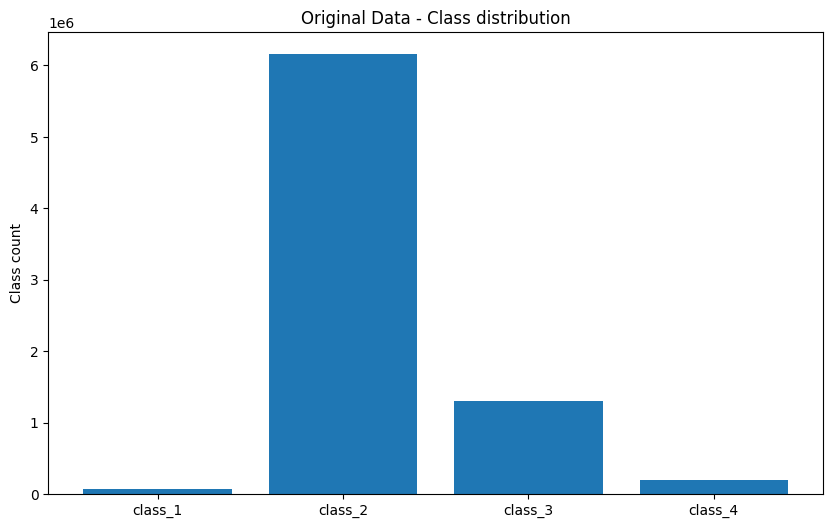

In [ ]:
plt.bar([1,2,3,4], [class_counts[k] for k in [1,2,3,4]])
plt.xticks([1,2,3,4], labels=[f"class_{i}" for i in range(1,5)])
plt.title("Original Data - Class distribution")
plt.ylabel("Class count")
plt.show()

- we do not aim to work on whole of the data but rather sample a little and work on it
- Looking at the highly skewed data, it's clear that we cannot simply perform probabilistic sampling since it might result into a sample with very minimal to no minority classes
- So, we would rather do a deterministic sampling where we aim to pick certain number of samples from each class

## Trying various sampling methods

### I. Iterating over chunks and randomly picking few

In [ ]:
chunks = pd.read_csv(readcsv_path, chunksize = CHUNK_SIZE)

sample_df = pd.DataFrame()
chunk_df_list = []

for chunk in chunks:
    #wish to pick 50 random values
    #the last chunk might not have CHUNK_SIZE no. of samples,
    #so rather than hardcoding 50, we use nrows, which can be 50 or less for the last chunk
    nrows = chunk.shape[0]
    rand_idxs = random.sample(range(0, nrows), 50)
    chunk_df_list.append(chunk.iloc[rand_idxs, :])

sample_df = pd.concat(chunk_df_list)
del chunk_df_list
sample_df.shape

(368050, 46)

Text(0.5, 1.0, 'Random Sampling per chunk')

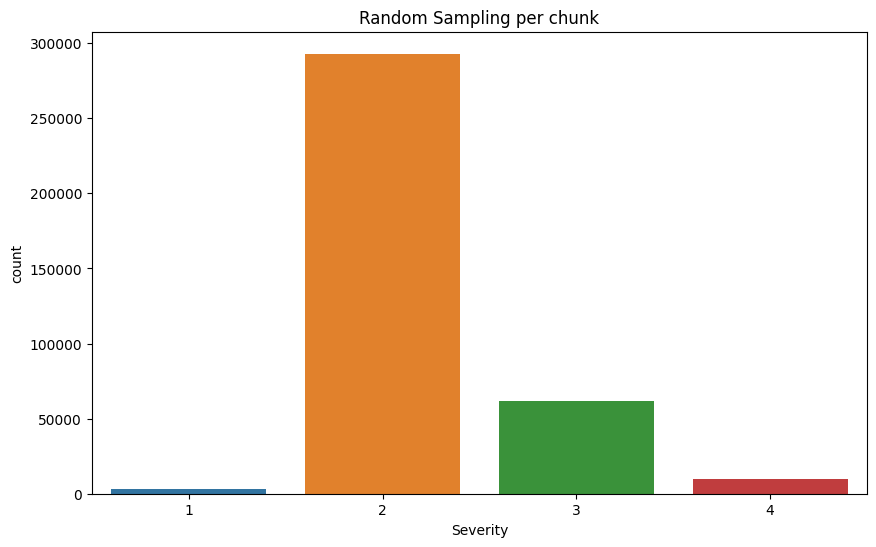

In [ ]:
sns.countplot(data=sample_df, x='Severity')
plt.title("Random Sampling per chunk")

In [ ]:
print("Percent of each class\n")
sample_df['Severity'].value_counts(normalize=True)*100

Percent of each class



2    79.596251
3    16.844450
4     2.676810
1     0.882489
Name: Severity, dtype: float64

### II. Sampling with aim to balance data

- The previous method though randomizes, it carries the same problem as original dataset
i.e., highly imbalanced dataset
- so we can rather pick certain percentages of each class accordingly to reduce imbalance
- At this point we intend to take only ~5L samples
- Class distribution
    - severity 1: ~68K records
    - severity 2: ~ 61.6L records
    - severity 3: ~ 13L records
    - severity 2: ~ 2.05L records
- So maybe we can pick 100%, 3-5%, 10% & 70% of class 1,2,3,& 4 respec.

In [ ]:
# This will be the percentage of each class we'll pick at random
CLASS_FRACTION = {
    1: 1,
    2: 0.03,
    3: 0.1,
    4: 0.7
}

#### II.I Sneak peek if we carefully perform sampling

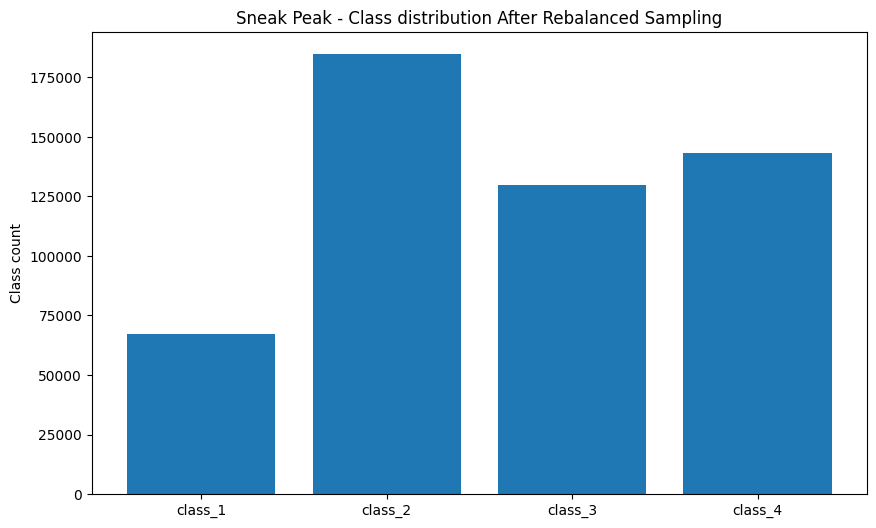

In [ ]:
after_rebalanced_sampling = {}

for class_ in range(1,5):
    after_rebalanced_sampling[class_] = round(class_counts[class_]*CLASS_FRACTION[class_],0)

plt.bar([1,2,3,4], [after_rebalanced_sampling[k] for k in [1,2,3,4]])
plt.xticks([1,2,3,4], labels=[f"class_{i}" for i in range(1,5)])
plt.title("Sneak Peak - Class distribution After Rebalanced Sampling")
plt.ylabel("Class count")
plt.show()

#### II.II Actually sampling the data using the above technique

In [ ]:
import time
#CAREFULLY RESAMPLING
chunks = pd.read_csv(readcsv_path, chunksize = CHUNK_SIZE, iterator=True)
balanced_sample_df = pd.DataFrame()
sample_df_list = []

start_time = time.time()

for i, chunk in enumerate(chunks):
    chunk_sampled_df = pd.DataFrame()
    for class_ in [1,2,3,4]:
        class_chunk = chunk.loc[chunk['Severity'] == class_, :]
        n_class_samples = class_chunk.shape[0]
        if n_class_samples == 0:
            continue
        n_class_samples_to_take = math.ceil(CLASS_FRACTION[class_] * n_class_samples)
        rnd_idxs = random.sample(range(0, n_class_samples), n_class_samples_to_take)
        chunk_sampled_df = pd.concat([chunk_sampled_df, class_chunk.iloc[rnd_idxs, :]])

    sample_df_list.append(chunk_sampled_df)

print("Total time (in secs): ",time.time() - start_time)

balanced_sample_df = pd.concat(sample_df_list)

Total time (in secs):  191.23093724250793


**IMPORTANT IMPLEMENTATION OBSERVATION**

- There are two ways to create final sampled df

    1. After each iteration keep concatenating to the sample df
    2. Just add the intermediate dfs to a list & finally concat at once

- When doing the same for 500 observation
    - Method 1: 21.721 seconds -- appending to same DF again and again
    - Method 2: 13.554 seconds -- appending to list and finally concatenating

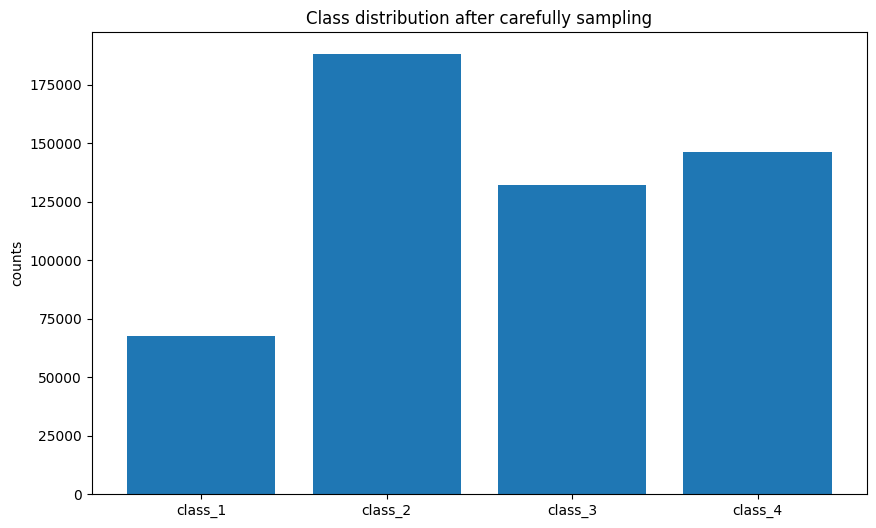

In [ ]:
balanced_sample_df.reset_index(drop=True, inplace=True)
counts = balanced_sample_df['Severity'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks(counts.index, labels=[f"class_{i}" for i in counts.index])
plt.title("Class distribution after carefully sampling")
plt.ylabel("counts")
plt.show()

#### Writing sampled data to csv

In [ ]:
balanced_sample_df.to_csv(tocsv_path, index=False, encoding='utf-8')

# Reading Data

In [ ]:
if ENV == 'colab':
    #we read and write to the drive
    readcsv_path = "/content/gdrive/MyDrive/CSCE - 5215 - ML Project/US_Accidents_March23.csv"
else:
    readcsv_path = "/kaggle/input/us-accidents/US_Accidents_March23.csv"

In [ ]:
def load_data():
    df = None
    if ENV == 'colab':
        from google.colab import drive
        drive.mount('/content/gdrive')
        # READING THE CSV
        df = pd.read_csv('/content/gdrive/MyDrive/CSCE - 5215 - ML Project/balanced_sample_df.csv')
    elif ENV == 'kaggle':
        df = pd.read_csv(f"/kaggle/input/d/{kaggle_uname}/balanced-sample-df/balanced_sample_df.csv")

    return df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# READING THE CSV
df = load_data()

# EDA

**Columns we do not need:** ID, source, timezone, Description, street, country, airport_code, weather_timestamp, civil_twilight, nautical_twilight, astronomical_twilight

In [ ]:
df.columns = df.columns.map(lambda col: col.lower())

df = df.drop(
    ['id', 'source', 'timezone', 'end_lat', 'end_lng', 'description', 'street', 'country', 'airport_code', 'weather_timestamp',
     'civil_twilight', 'nautical_twilight', 'astronomical_twilight'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533514 entries, 0 to 533513
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   severity           533514 non-null  int64  
 1   start_time         533514 non-null  object 
 2   end_time           533514 non-null  object 
 3   start_lat          533514 non-null  float64
 4   start_lng          533514 non-null  float64
 5   distance(mi)       533514 non-null  float64
 6   city               533486 non-null  object 
 7   county             533514 non-null  object 
 8   state              533514 non-null  object 
 9   zipcode            533339 non-null  object 
 10  temperature(f)     520967 non-null  float64
 11  wind_chill(f)      387511 non-null  float64
 12  humidity(%)        520177 non-null  float64
 13  pressure(in)       522698 non-null  float64
 14  visibility(mi)     519830 non-null  float64
 15  wind_direction     520669 non-null  object 
 16  wi

## Univarite analysis (EDA-I)
- Quick look through the data to preprocess the columns


The first task is to identify the type of each column i.e., continuous or categorical values

Categorical values

- severity (target col)
- city
- county
- state
- zipcode
- wind_direction
- weather_condition
- sunrise_sunset
- -> (All bool type)

Continuous

- distance(mi)
- temperature(f)
- wind_chill(f)
- humidity(%)
- pressure(in)
- visibility(mi)
- wind_speed(mph)
- precipitation(in)

Date -> need to be converted to date type

- start_time
- end_time

**WEATHER_CONDITION**

In [ ]:
print("Unique weather conditions")
print(df['weather_condition'].unique())

print("\n\nNo. of Unique weather conditions", len(df['weather_condition'].unique()))

Unique weather conditions
['Overcast' 'Light Rain' 'Clear' 'Light Snow' 'Scattered Clouds'
 'Mostly Cloudy' 'Haze' nan 'Rain' 'Light Freezing Drizzle'
 'Partly Cloudy' 'Light Freezing Fog' 'Snow' 'Fog' 'Heavy Rain'
 'Light Drizzle' 'Thunderstorms and Rain' 'Smoke' 'Fair' 'Cloudy'
 'Blowing Sand' 'Widespread Dust' 'Rain Showers' 'Drizzle'
 'Showers in the Vicinity' 'Light Thunderstorms and Rain' 'Mist'
 'Patches of Fog' 'Thunderstorm' 'Heavy Thunderstorms and Rain'
 'Thunder in the Vicinity' 'Thunder' 'Light Freezing Rain' 'Shallow Fog'
 'Heavy Snow' 'Light Ice Pellets' 'Partly Cloudy / Windy' 'Light Fog'
 'Fair / Windy' 'Ice Pellets' 'Small Hail' 'Heavy T-Storm' 'Funnel Cloud'
 'Light Rain Showers' 'T-Storm' 'Light Rain with Thunder'
 'Heavy T-Storm / Windy' 'Thunder / Windy' 'Light Rain / Windy'
 'Mostly Cloudy / Windy' 'Cloudy / Windy' 'T-Storm / Windy'
 'Heavy Rain / Windy' 'Haze / Windy' 'Tornado' 'Light Rain Shower'
 'N/A Precipitation' 'Drizzle and Fog' 'Light Drizzle / Windy'
 '

In [ ]:
val_counts = df['weather_condition'].value_counts()
val_counts = val_counts.sort_values(ascending=False)

print("--> Top 20 weather conditions")
print(val_counts.iloc[:20])

print("\n--> Least 20 repeating weather conditions")
print(val_counts.iloc[-20:])

--> Top 20 weather conditions
Fair                       169250
Mostly Cloudy               71084
Clear                       60247
Cloudy                      55213
Partly Cloudy               47928
Overcast                    29628
Light Rain                  24367
Scattered Clouds            15148
Light Snow                   8760
Fog                          6204
Rain                         5776
Haze                         4237
Fair / Windy                 2413
Heavy Rain                   2241
Light Drizzle                1686
T-Storm                      1153
Thunder in the Vicinity      1139
Cloudy / Windy               1130
Snow                         1128
Mostly Cloudy / Windy        1107
Name: weather_condition, dtype: int64

--> Least 20 repeating weather conditions
Light Snow with Thunder         2
Patches of Fog / Windy          2
Heavy Sleet                     2
Drifting Snow / Windy           2
Thunderstorms and Snow          1
Volcanic Ash                    1
Heavy

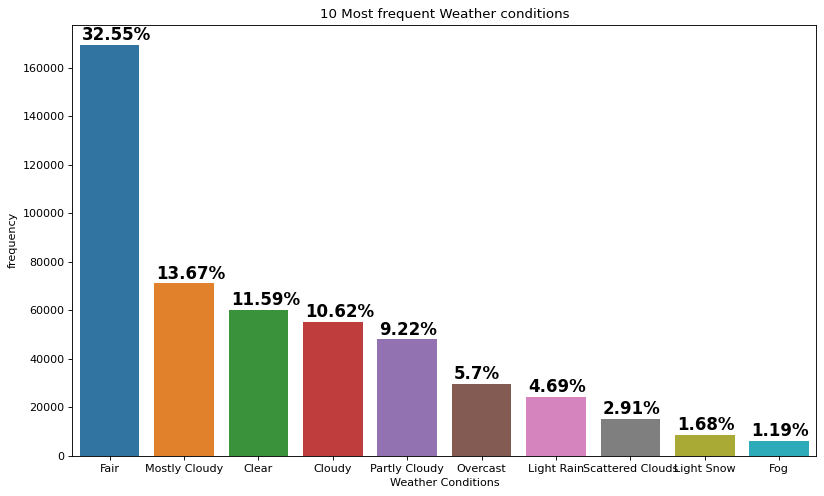

In [ ]:
fig, ax = plt.subplots(figsize = (12,7), dpi = 80)
sns.barplot(x=val_counts.index[:10], y=val_counts.iloc[:10])

total = val_counts.sum()

for i in ax.patches:
    ax.text(i.get_x()+.03, i.get_height()+2000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='black')

plt.title("10 Most frequent Weather conditions")
plt.xlabel("Weather Conditions")
plt.ylabel("frequency")
plt.show()

Weather condition

- Has 106 unqiue categorical values
- Around 10 values cover almost 90% of the samples, rest rarely appear

- Y do we need to process this?
  - Since the data has been pulled from various APIs many diff values might have almost similar interpretation
  - Defining relative order among the values can be very diff inorder to apply label/ordinal encoding
  - one-hot will create a lot of sparse data
- Possible Solution?
  - Retain only the most common values and drop the others
  - Carefully aggregate various values into broader categories

**WIND_DIRECTION**

In [ ]:
print("Unique wind directions")
print(df['wind_direction'].unique())

Unique wind directions
['SSE' 'East' 'WNW' 'South' 'SE' 'West' 'NW' 'SSW' 'WSW' 'SW' 'Calm' nan
 'NE' 'ESE' 'NNE' 'Variable' 'NNW' 'ENE' 'North' 'E' 'S' 'CALM' 'VAR' 'N'
 'W']


![Reading wind directions](	https://www.surfertoday.com/images/stories/compassrose.jpg)

Wind Direction
- we have a lot of different unqiue values
- But a few are just duplicates i.e., West and W are the same, North & N are the same similarly, S & South, E & East, CALM & Calm, Variable & VAR

**SUNRISE_SUNSET**

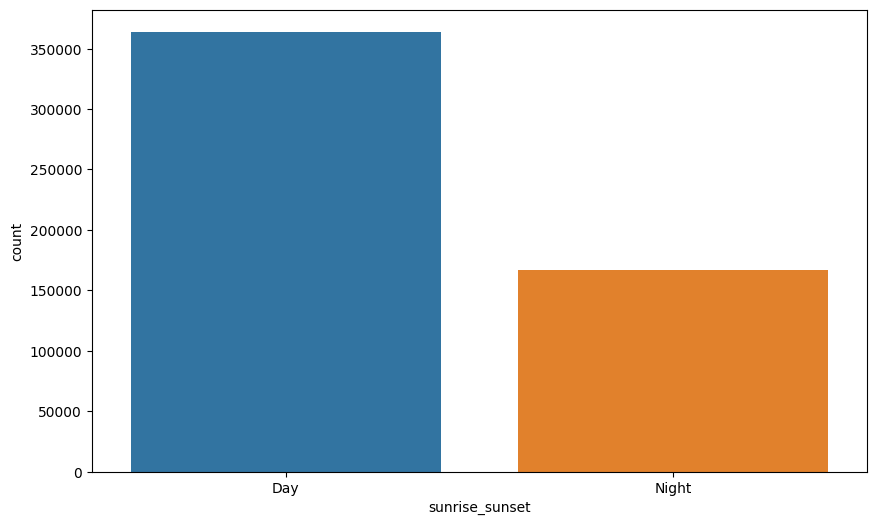

In [ ]:
sns.countplot(data = df, x = 'sunrise_sunset')
plt.show()

**Observation**
- Signals that majority of accidents are happening during the day time

**BOOLEAN TYPE COLUMNS**

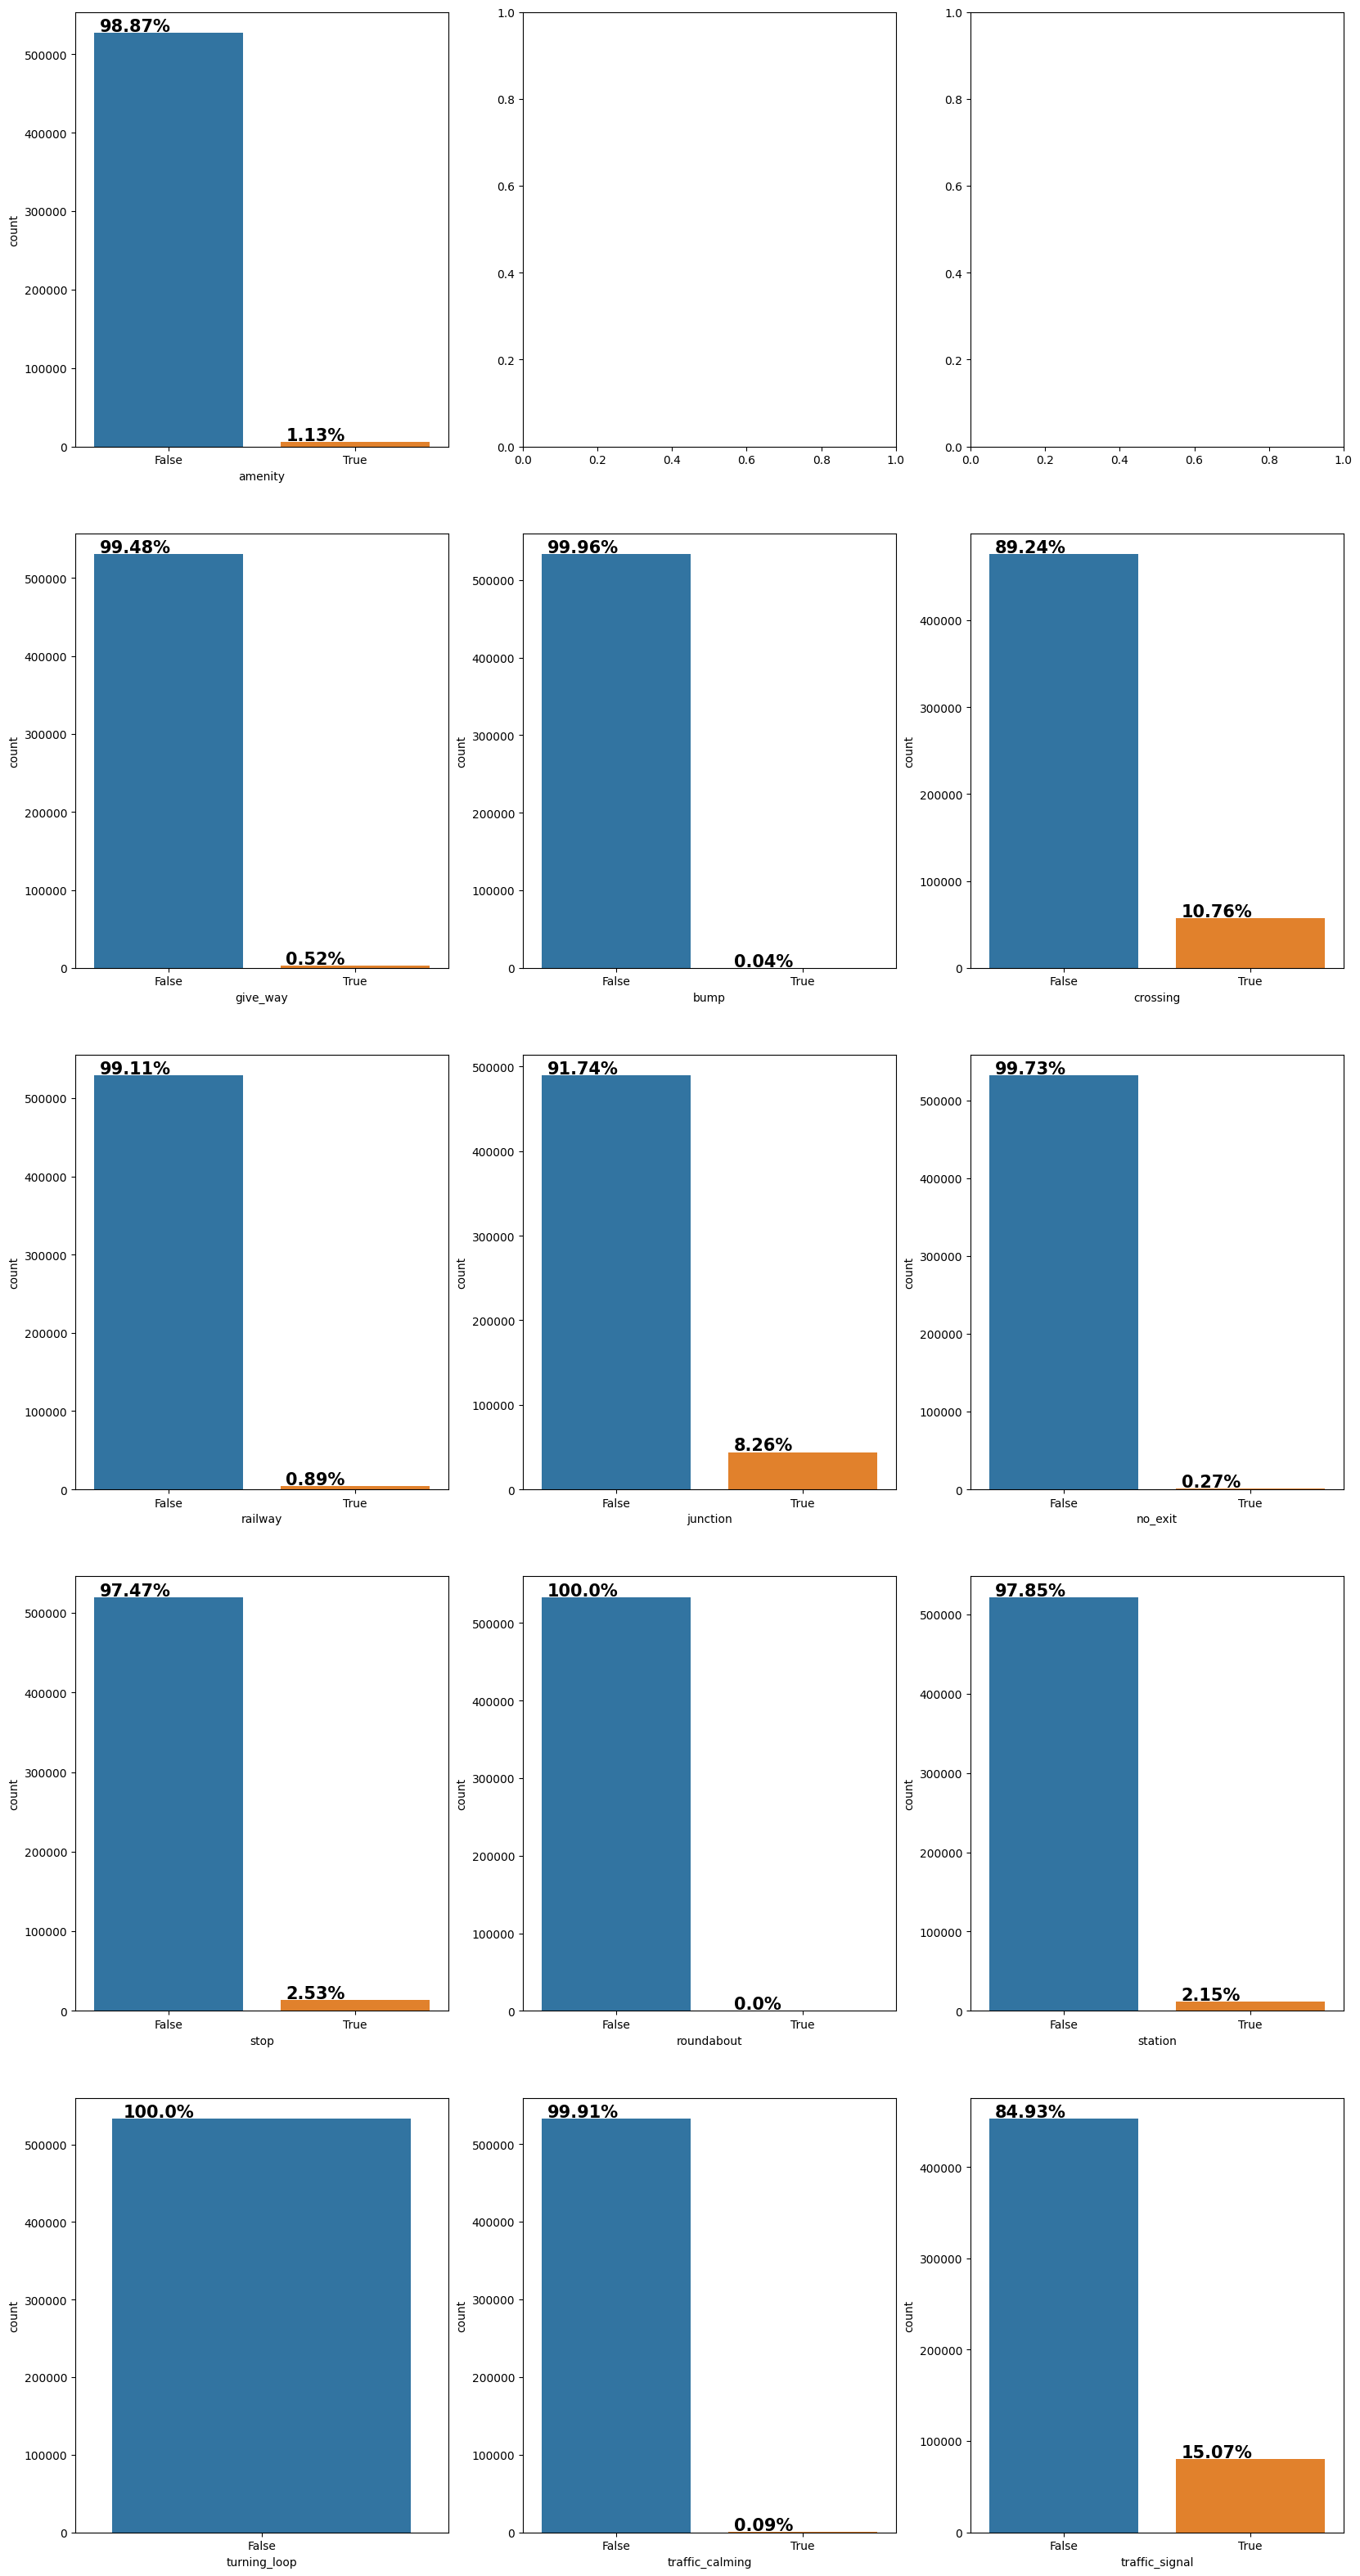

In [ ]:
def getNrowsnColNames(data, dtype, plots_per_row):
    bool_type_cols = data.select_dtypes(dtype).columns
    ncols = len(bool_type_cols)
    nrows = math.ceil(ncols/plots_per_row)

    return (nrows, bool_type_cols)

ncols = 3
nrows, bool_type_cols = getNrowsnColNames(df, 'bool', ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))

total = df.shape[0]

for i, col in enumerate(bool_type_cols):
    r = math.ceil(i/ncols)
    c = i%ncols
    axes = axs[r][c]
    sns.countplot(data=df, x = col, ax = axes)

    #writing percentages on each bar
    for p in axes.patches:
        axes.text(p.get_x()+.03, p.get_height()+2000, \
            str(round((p.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='black')

plt.show()

All boolean data observation

- False constitutes majority of the data
- Infact, roundabout & turning_loop are 100% False

**NUMERIC COLUMNS**

In [ ]:
def groupPlotNumericCols(df, plot_type, ncols):
    nrows, cont_type_cols = getNrowsnColNames(df, 'float64', ncols)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))

    total = df.shape[0]

    for i, col in enumerate(cont_type_cols):
        r = math.ceil(i/ncols)
        c = i%ncols
        axes = axs[r][c]
        #plotting
        if plot_type == 'box':
            sns.boxplot(data=df, y = col, ax = axes)
        elif plot_type == 'hist':
            sns.histplot(data=df, x = col, ax = axes)

    plt.show()

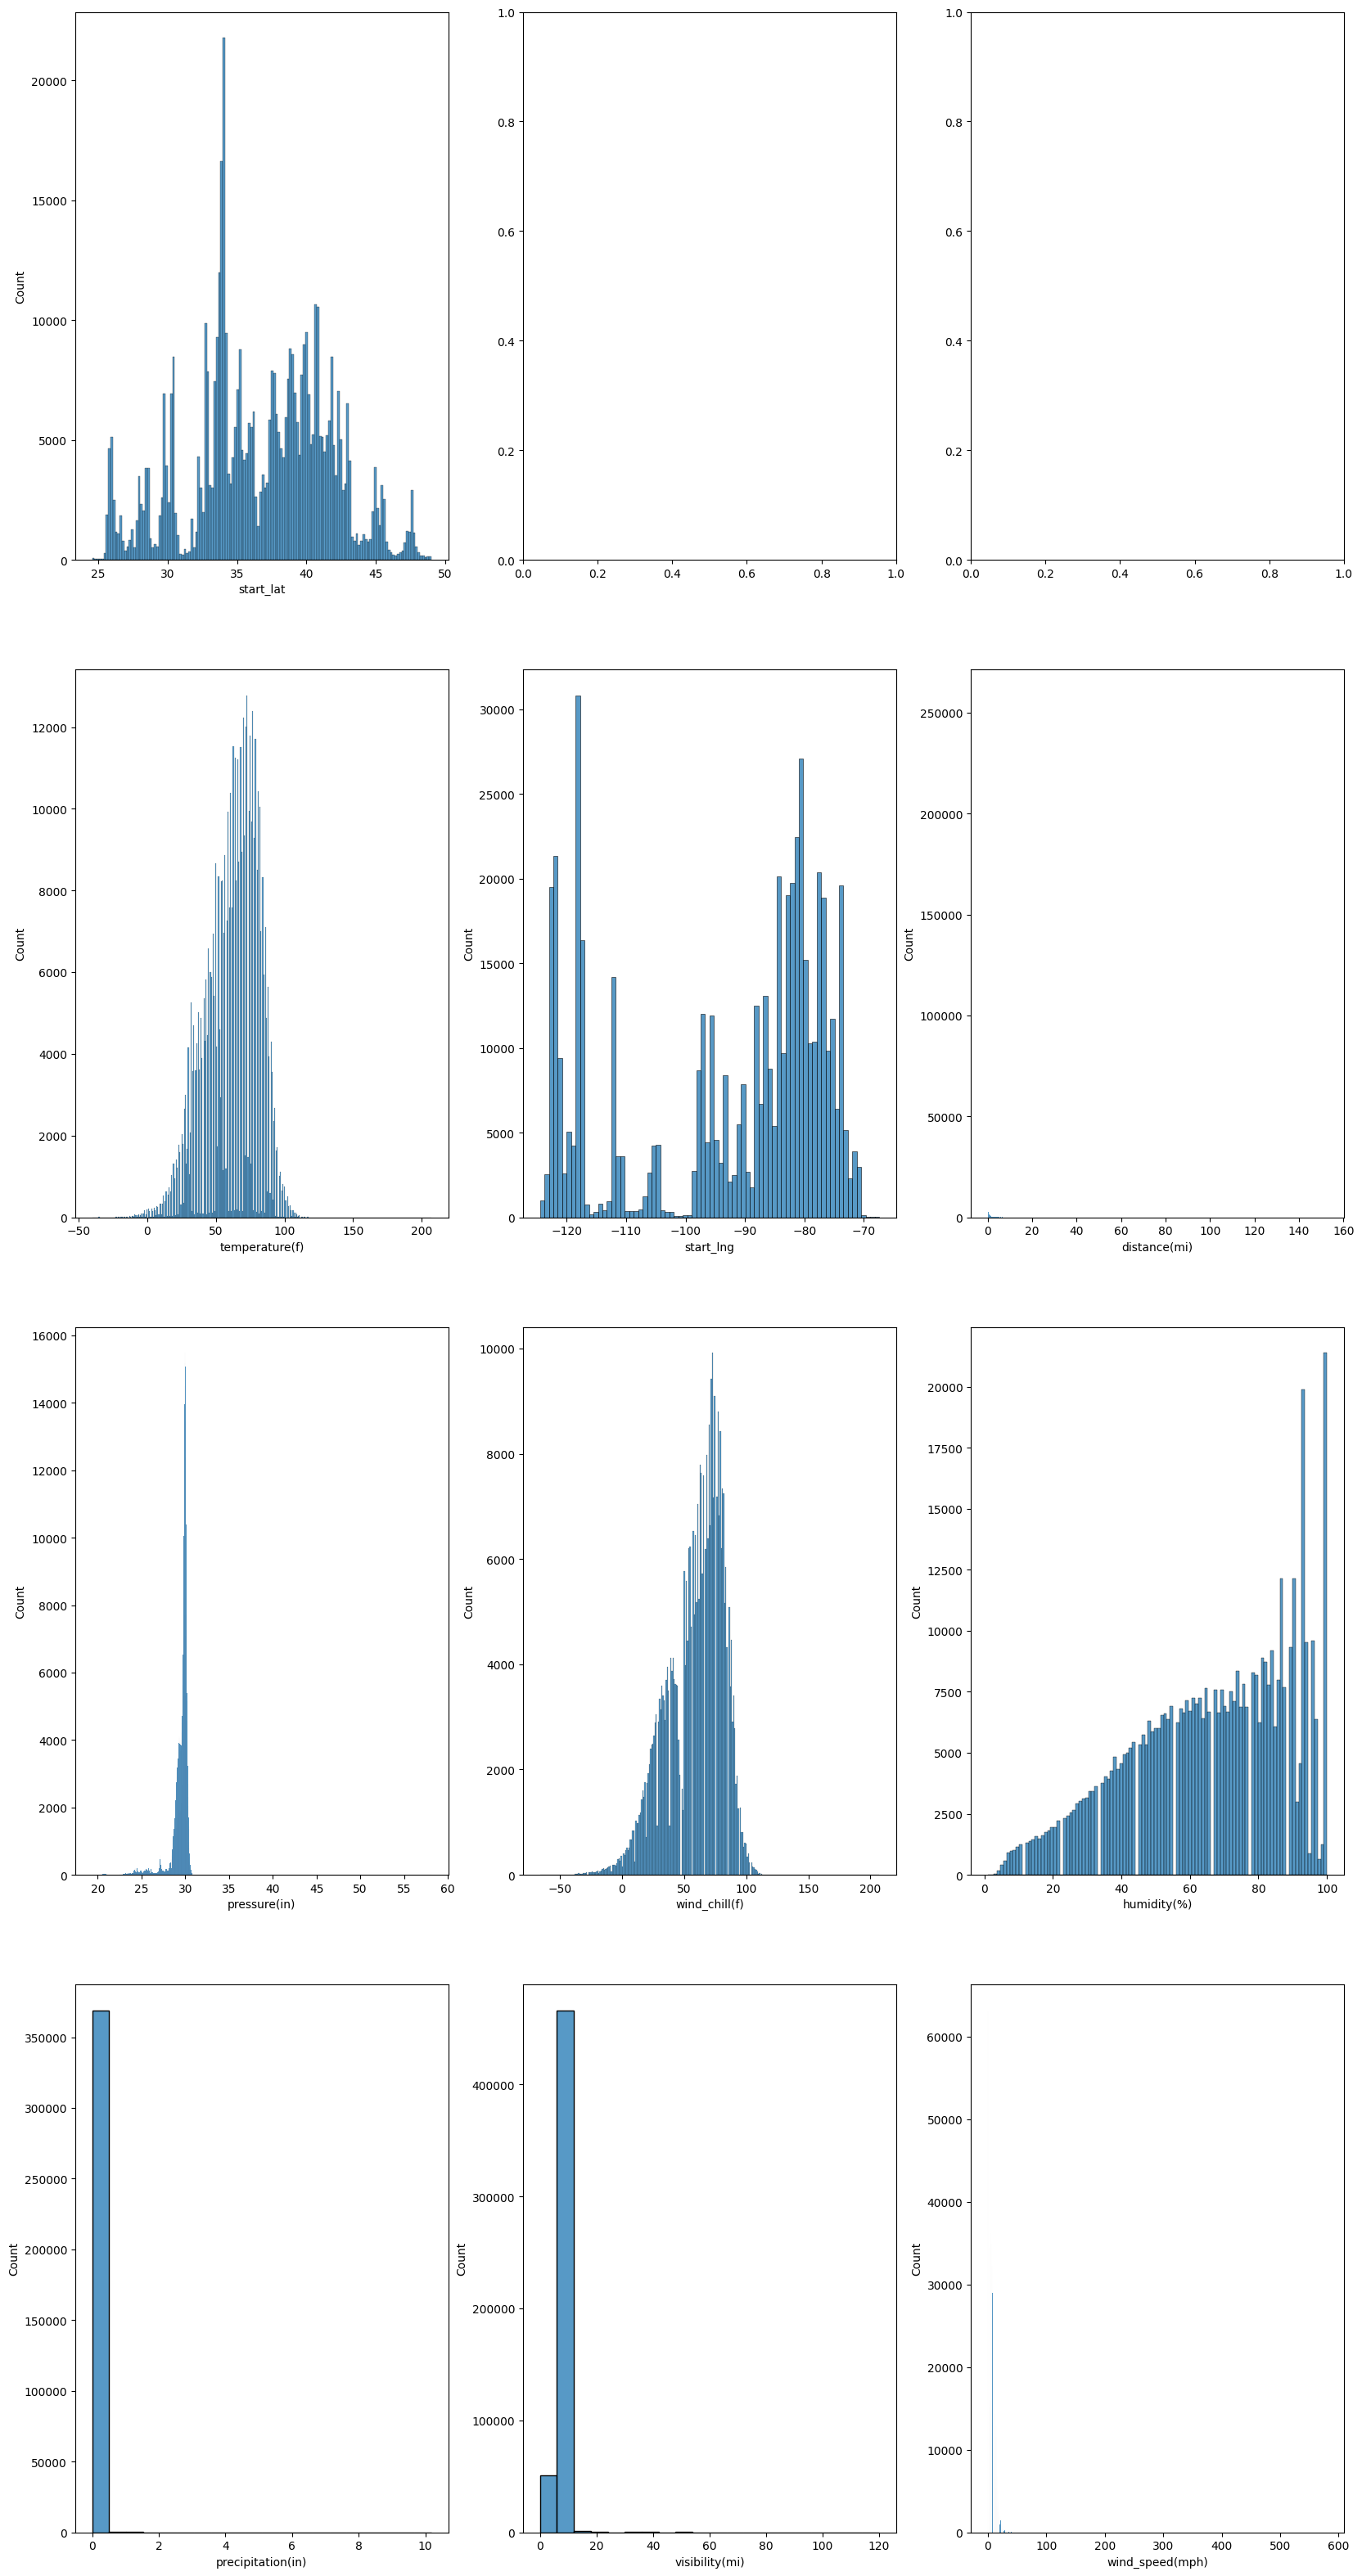

In [ ]:
groupPlotNumericCols(df, plot_type='hist', ncols=ncols)

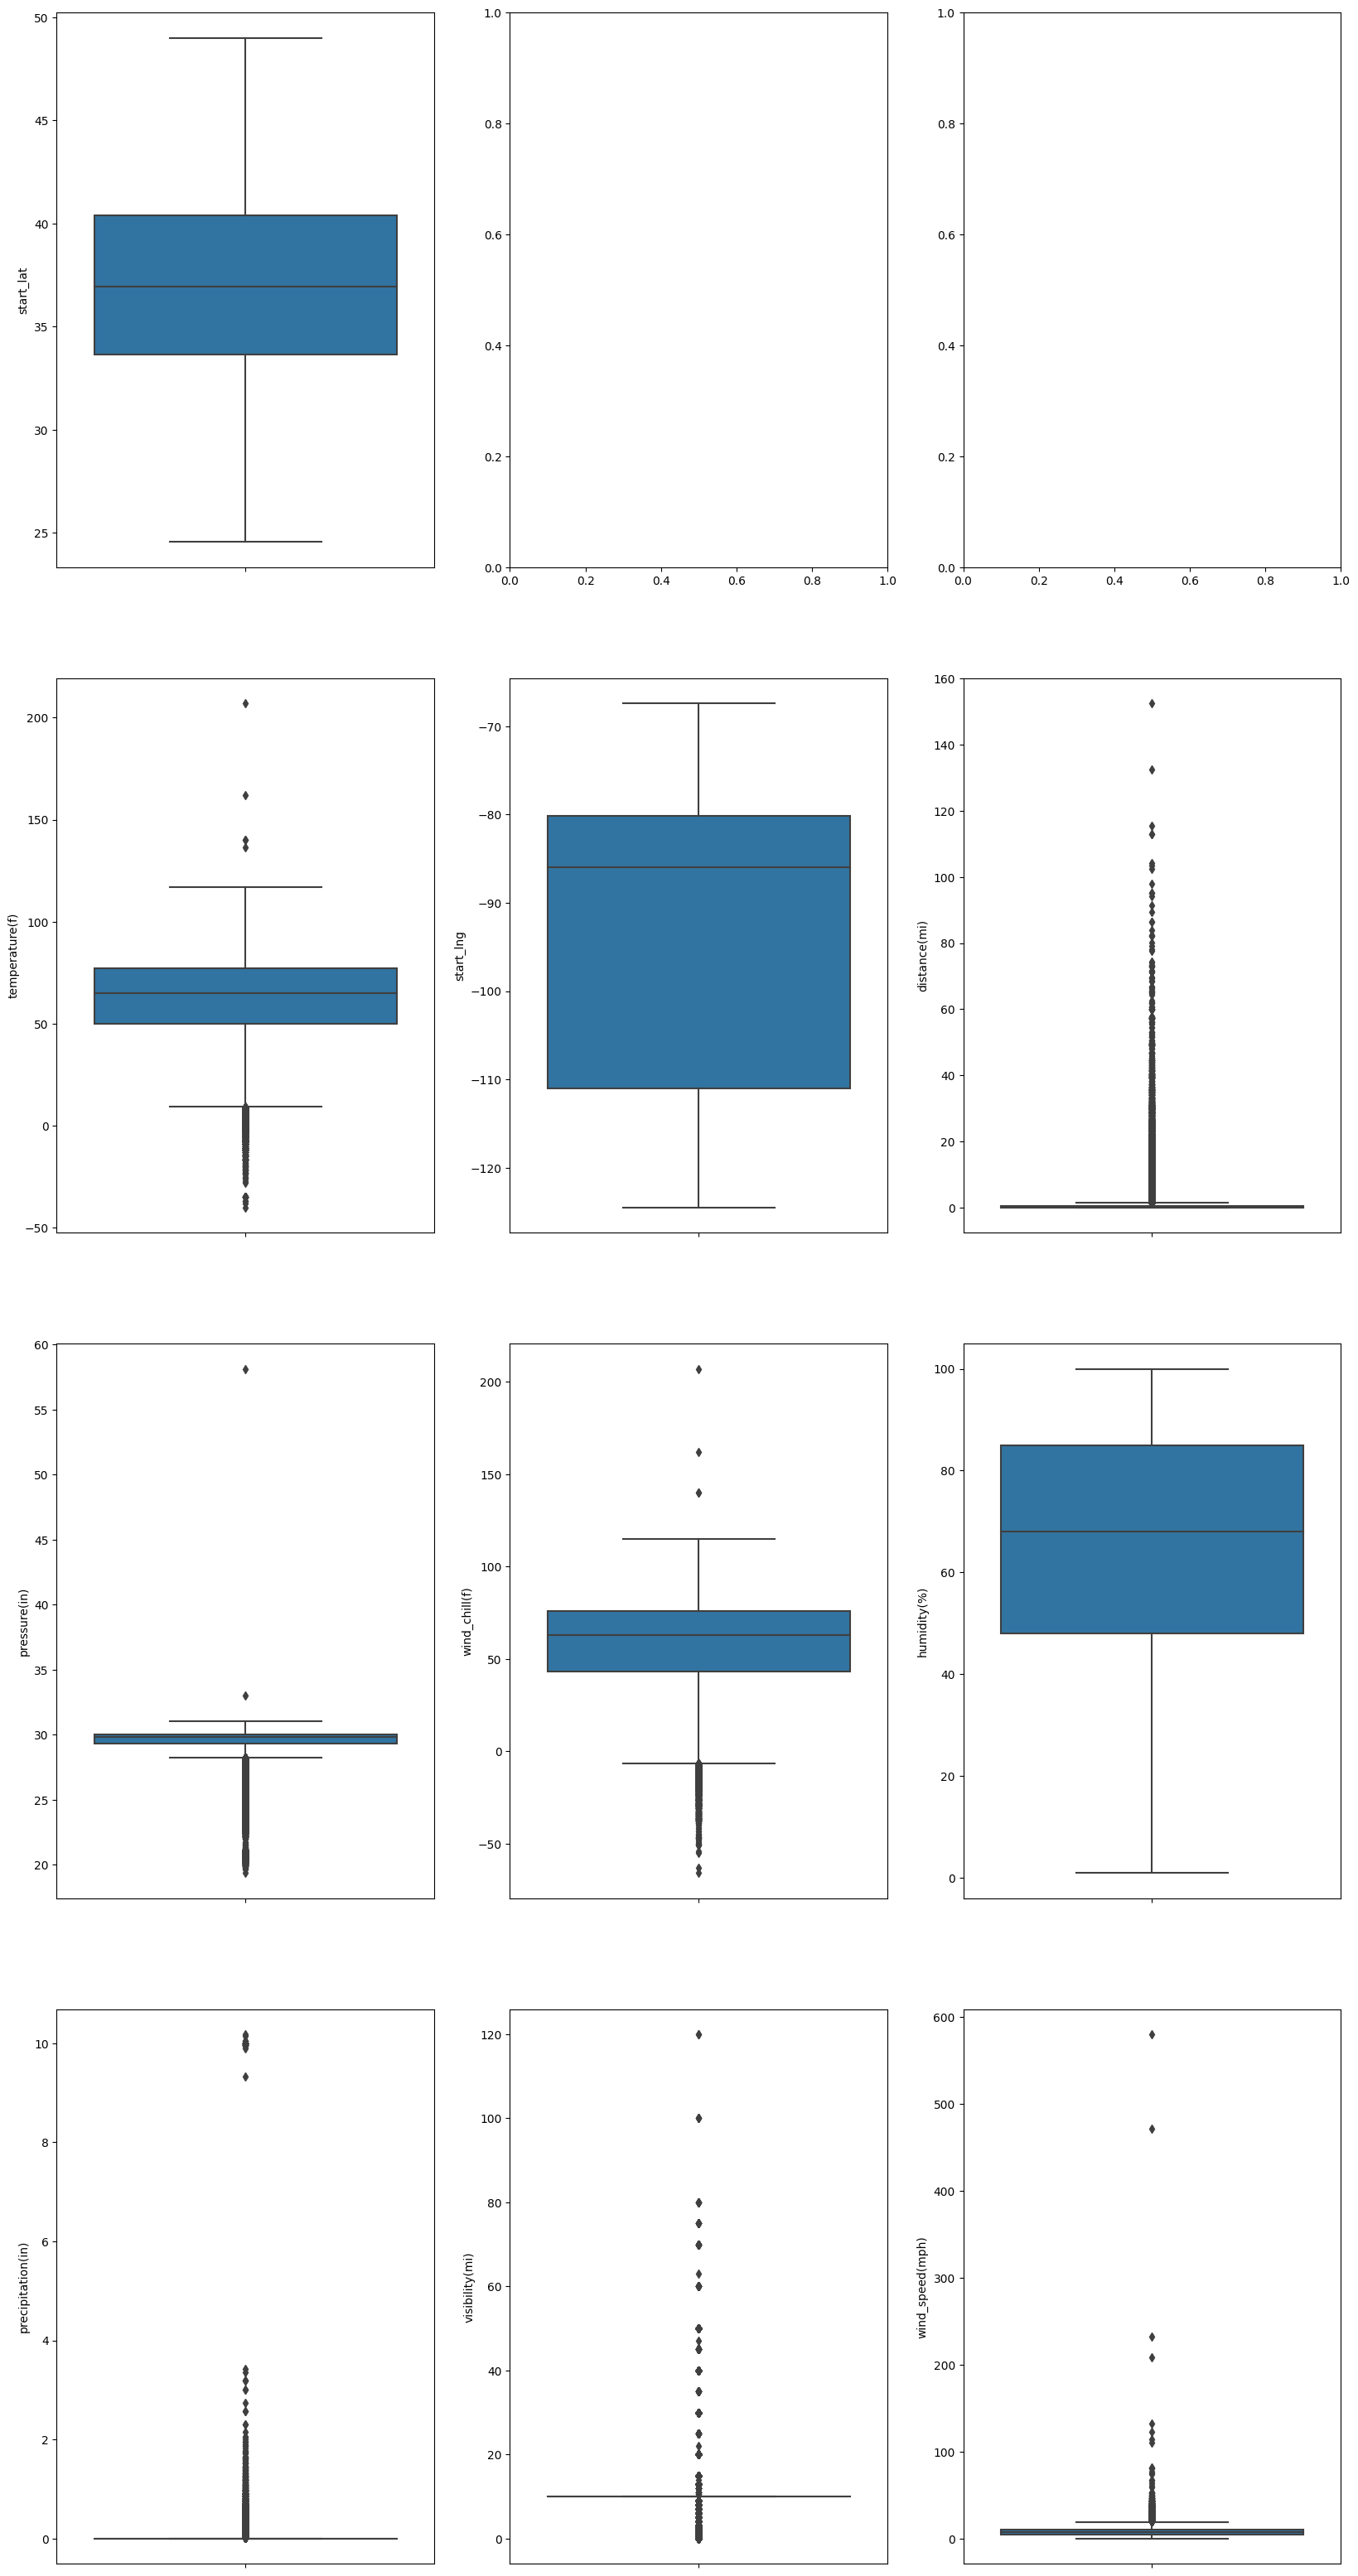

In [ ]:
groupPlotNumericCols(df, plot_type='box', ncols=ncols)

**Observation**
- There are a lot of outliers
- the distribution is NOT normal

# Preprocessing Individual Columns

## Treating Duplicates in Categorical features

weather_condtions, wind_direction

### 1. Binning Weather Condition Column

In [ ]:
weather_bins = {
    'Clear': ['Clear', 'Fair', 'Fair / Windy'],
    'Foggy/not clear': [
        'Patches of Fog', 'Light Freezing Fog', 'Drizzle and Fog', 'Fog / Windy', 'Smoke / Windy', 'Widespread Dust / Windy',
        'Patches of Fog / Windy', 'Partial Fog', 'Partial Fog / Windy', 'Sand / Dust Whirlwinds / Windy',
        'Blowing Sand', 'Blowing Dust / Windy','Duststorm', 'Sand / Dust Whirls Nearby'
    ],
    'Cloudy': [
        'Cloudy', 'Mostly Cloudy', 'Mostly Cloudy / Windy', 'Partly Cloudy', 'Scattered Clouds', 'Funnel Cloud', 'Sand / Dust Whirlwinds', 'Mist / Windy','Overcast'
    ],
    'Rainy': ['Light Rain', 'Rain', 'Light Freezing Drizzle', 'Light Drizzle', 'Light Freezing Rain', 'Drizzle', 'Light Rain Showers',
              'Showers in the Vicinity', 'Rain / Windy', 'Squalls', 'Thunder', 'Thunder / Windy',
               'Haze / Windy', 'Light Drizzle / Windy', 'Wintry Mix', 'Wintry Mix / Windy', 'Sleet / Windy',
              'Squalls / Windy', 'Light Rain Shower / Windy', 'Snow and Thunder / Windy', 'Light Sleet / Windy',
                'Drizzle / Windy', 'Thunder and Hail', 'Freezing Rain / Windy',
               'Thunder / Wintry Mix / Windy', 'Rain and Sleet', 'Light Hail', 'Light Thunderstorm',
              'Heavy Freezing Drizzle',  'Thunderstorms and Snow', 'Light Rain / Windy',
              'Heavy Rain Showers', 'Rain Shower / Windy', 'Sleet and Thunder', 'Thunder and Hail / Windy',
              'Heavy Sleet / Windy', 'Sand / Windy', 'Freezing Rain / Windy'
             ],
    'Extremes': [
        'Heavy Rain', 'T-Storm', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Snow', 'Heavy Rain / Windy', 'tornado',
        'Heavy Ice Pellets', 'T-Storm / Windy', 'Heavy Freezing Rain / Windy', 'Heavy Snow with Thunder', 'Heavy Blowing Snow', 'Shallow Fog / Windy', 'Heavy Sleet and Thunder',
        'Heavy Thunderstorms with Small Hail', 'Hail', 'Heavy Rain Shower / Windy', 'Heavy Rain Shower', 'T-Storm / Windy', 'Heavy Rain Shower / Windy', 'Sleet and Thunder / Windy'
    ],

    'Snowy': [
        'Light Snow', 'Snow', 'Light Snow / Windy', 'Snow Grains', 'Snow Showers', 'Snow / Windy', 'Light Snow and Sleet', 'Snow and Sleet',
        'Light Snow and Sleet / Windy', 'Snow and Sleet / Windy', 'Blowing Snow / Windy','Light Snow and Sleet / Windy','Blowing Snow Nearby',
        'Blowing Snow Nearby', 'Drifting Snow','Light Snow with Thunder', 'Snow and Thunder','Light Blowing Snow','Light Snow Shower / Windy',
        'Light Snow Grains', 'Low Drifting Snow', 'Drifting Snow / Windy'
    ]
}

#changing all the values of bin to lower case
for bin_name, bin_values in weather_bins.items():
  weather_bins[bin_name] = [val.lower() for val in bin_values]

- The above can have a few misclassifications since all the values have been scanned manually to observe a pattern and possible major categories

Following are a few along with pattern

1. Clear: contains clear or fair
2. Cloudy: contains cloud or overcast
3. Fog/Not clear: contains fog, sand, dust,smoke
4. Extreme: contains Heavy, Hail, T-Storm, sleet and not light
5. snowy: contains snow
6. Rainy: contains Rain, shower, sleet, thunder, drizzle, drizzling, winter
7. other: unmatched or unknown

In [ ]:
weather_patterns = [
      ('clear', re.compile('fair|clear',re.IGNORECASE)),
      ('cloudy', re.compile('cloud|overcast',re.IGNORECASE)),
      ('fog/notClear', re.compile('fog|sand|dust|smok(e|y)',re.IGNORECASE)),
      ('extreme', re.compile('heavy|heavily|hail|t-storm|tornado', re.IGNORECASE)), # SHOULD NOT CONTAIN word LIGHT
      ('snowy', re.compile('snow', re.IGNORECASE)),
      ('rainy', re.compile(r'rain|drizzl(e|ing)|sleet|thunder|winter|drop|shower', re.IGNORECASE))
]

def weather_mapping(weather):
  for label, pattern in weather_patterns:
    if pattern.search(str(weather)):
      return label
  return "other"

def map_weather_to_bins(weather):
  weather = str(weather).lower()
  for bin_name, bin_values in weather_bins.items():
    if weather in bin_values:
      return bin_name
  return 'Other'

In [ ]:
#USING REGEX Mapping
df['weather_bins_regex'] = df['weather_condition'].apply(weather_mapping)

In [ ]:
# USING MANUAL MAPPING
df['weather_bins_manual'] = df['weather_condition'].apply(map_weather_to_bins)

In [ ]:
df['weather_bins_regex'].value_counts(normalize=True)

clear           0.434684
cloudy          0.416021
rainy           0.070073
other           0.035842
snowy           0.019765
fog/notClear    0.014303
extreme         0.009312
Name: weather_bins_regex, dtype: float64

In [ ]:
df['weather_bins_manual'].value_counts(normalize=True)

Clear              0.434684
Cloudy             0.412572
Rainy              0.065893
Other              0.058034
Snowy              0.019626
Extremes           0.008393
Foggy/not clear    0.000797
Name: weather_bins_manual, dtype: float64

### 2. Mapping duplicate data in Wind Direction column

In [ ]:
wind_mappings = {
    'south': ['south', 's'],
    'north': ['north', 'n'],
    'east': ['east', 'e'],
    'west': ['west', 'w'],
    'var': ['variable', 'var']
}

def map_wind_dir(wind_dir):
  wind_dir = str(wind_dir).lower()
  for label, vals in wind_mappings.items():
    if wind_dir in vals:
      return label

  return wind_dir

In [ ]:
df['wind_direction_mapped'] = df['wind_direction'].apply(map_wind_dir)
df['wind_direction_mapped'].unique()

array(['sse', 'east', 'wnw', 'south', 'se', 'west', 'nw', 'ssw', 'wsw',
       'sw', 'calm', 'nan', 'ne', 'ese', 'nne', 'var', 'nnw', 'ene',
       'north'], dtype=object)

### 3. Dropping boolean columns that are 100% False

- Since, they essentially signal nothing
- There are two such features -- roundabout, turning_loop

In [ ]:
df.drop(['roundabout', 'turning_loop'], axis = 1, inplace = True)

## Treating outliers in Numeric features
- possible solutions
    - Log transformation
    - if very few are outliers remove them
    - If significant
        - check if signaling something for eg: very high precipitation might actually signal a T-storm

In [ ]:
df2 = df.copy()
df2.shape

(533514, 34)

In [ ]:
def plotBoxNhist(data, col, title):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
    sns.boxplot(data = data, y=col, ax=axes[0])
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("range")
    axes[0].set_title(f"{title} Boxplot")

    plt.hist(data[col])
    # sns.histplot(data=data, x=col, ax=axes[1])
    axes[1].set_xlabel(col)
    axes[1].set_title(f"{title} histPlot")

    plt.show()

### 1. Visibility(mi)

In [ ]:
df2['visibility(mi)'].describe()

count    519830.000000
mean          9.137307
std           2.718925
min           0.000000
25%          10.000000
50%          10.000000
75%          10.000000
max         120.000000
Name: visibility(mi), dtype: float64

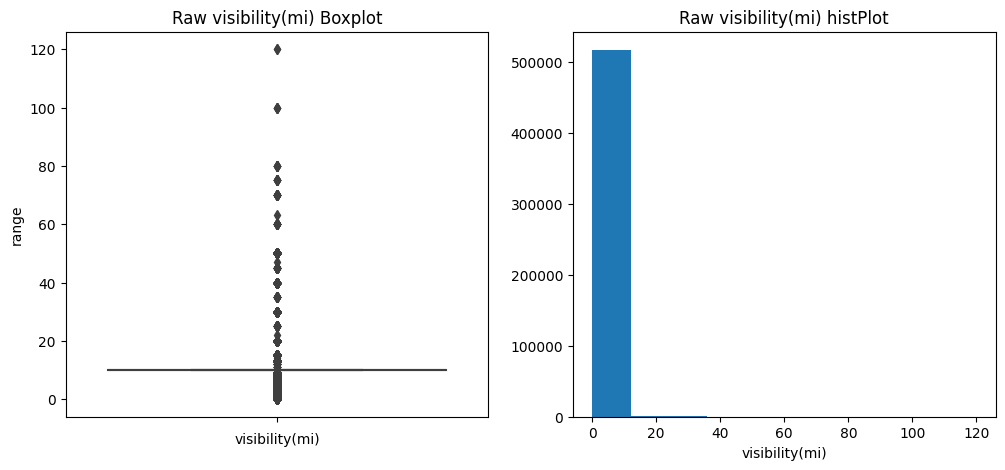

In [ ]:
plotBoxNhist(df2, 'visibility(mi)', 'Raw visibility(mi)')

**Observation**
- Min visibility is not less than 0, that's good
- but the max is 120 Miles. That's too large even on a very clear day.
- According to stats, max visibility on a clear day of a human eye is 3-5 miles max. The range extends a little if there is an elevation.

In [ ]:
print("99.8 percentile of visibility:", df2['visibility(mi)'].quantile(0.998))
print("99.9 percentile of visibility:", df2['visibility(mi)'].quantile(0.999))

99.8 percentile of visibility: 20.0
99.9 percentile of visibility: 30.0


- 99.8% of visibility data is <= 20 miles
- 99.9% <= 30 miles

In [ ]:
chopped_df2 = df2[df2['visibility(mi)'] > df2['visibility(mi)'].quantile(0.999)]
print("Number of samples with visibility > 99.9% of data:",chopped_df2.shape[0])
print("Number of severities captured:\n", chopped_df2['severity'].value_counts(),sep='')

Number of samples with visibility > 99.9% of data: 500
Number of severities captured:
3    189
4    162
2    138
1     11
Name: severity, dtype: int64


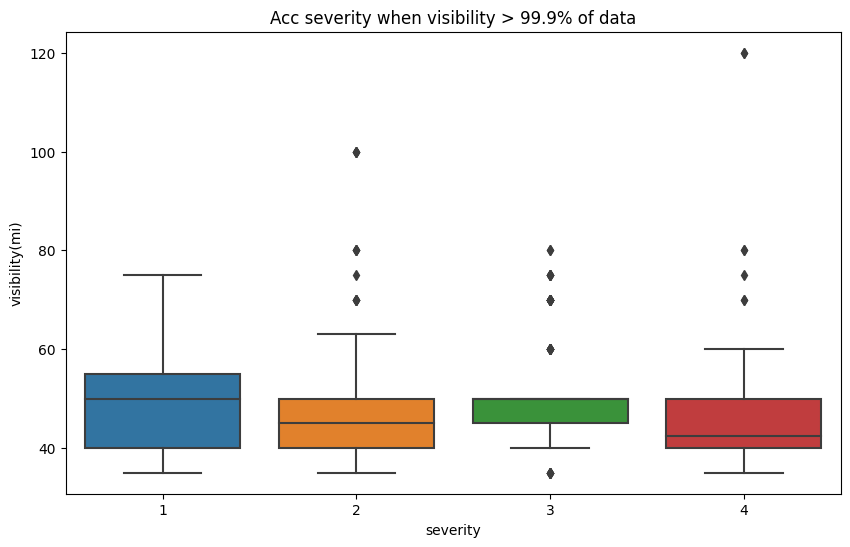

In [ ]:
sns.boxplot(data=chopped_df2, x = 'severity', y='visibility(mi)')
plt.title("Acc severity when visibility > 99.9% of data")
plt.show()

**Observation**
- Can be seen that, the outliers are highly random, and do not point to any specific case
- For eg:
    - samples are almost equally distributed among all severity levels expect 1

- Thus, very few and insignificant outliers.So, **Removing outliers**

In [ ]:
VISIBILITY_UPPER_LIMIT = df2['visibility(mi)'].quantile(0.999)
prev_tot = df2.shape[0]
df2 = df2[~df2.index.isin(chopped_df2.index)]
print(prev_tot - df2.shape[0])

500


- It doesn't make sense to remove visibility outliers that are on the lower side. Since, there is a high possibility of accident when it's low

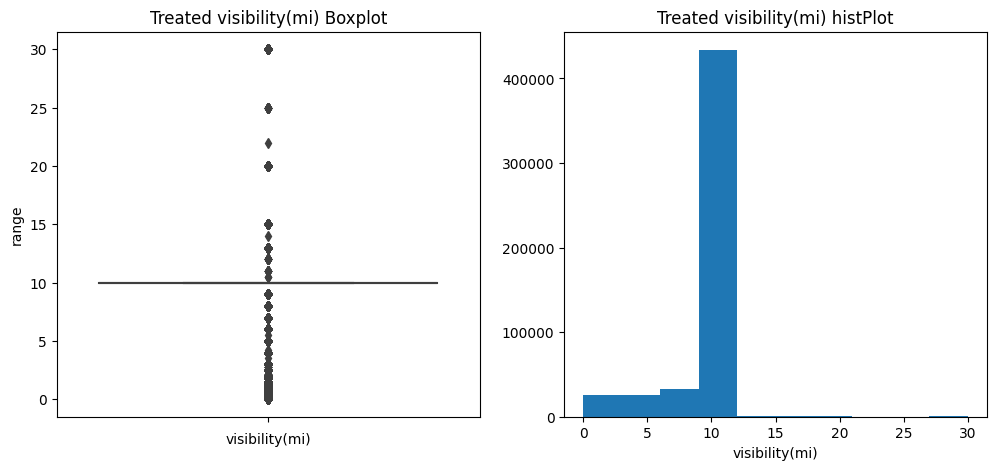

In [ ]:
plotBoxNhist(df2, 'visibility(mi)', 'Treated visibility(mi)')

### 2. Precipitation(in)

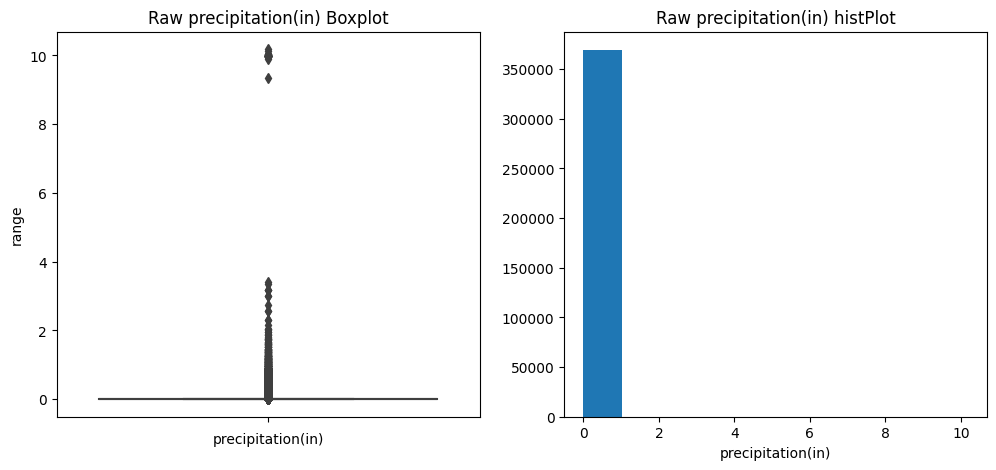

In [ ]:
plotBoxNhist(df2, 'precipitation(in)', 'Raw precipitation(in)')

In [ ]:
df2['precipitation(in)'].describe()

count    369402.000000
mean          0.009028
std           0.121188
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.180000
Name: precipitation(in), dtype: float64

In [ ]:
# Since precipitation is highly correlated with weather condition,
# let's desciribe it based on weather

df2.groupby('weather_bins_regex', )['precipitation(in)'].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,166012.0,0.001120,0.098269,0.0,0.00,0.00,0.00,10.05
cloudy,142328.0,0.003912,0.133930,0.0,0.00,0.00,0.00,10.18
extreme,4756.0,0.174708,0.271508,0.0,0.02,0.09,0.22,3.42
fog/notClear,6202.0,0.001421,0.015601,0.0,0.00,0.00,0.00,0.61
other,5697.0,0.013658,0.267285,0.0,0.00,0.00,0.00,10.04
rainy,34825.0,0.045214,0.094730,0.0,0.00,0.01,0.05,1.96
snowy,9582.0,0.010437,0.026811,0.0,0.00,0.00,0.01,1.43


**Observation**
- **Clear** days cannot have precipitation. Though 25, 50 & 75 percentile of clear shows 0 precipitation, its max shows 10.5.
- few might not be outliers but actual values, since it is possible to have heavy rains in extreme/rainy weather conditions.
- But It's a **sure outlier**, if weather condition is clear

In [ ]:
PRECIPI_UPPER_LIMIT = df2['precipitation(in)'].quantile(0.9998)
print("99.98 percentile of precipitation:", PRECIPI_UPPER_LIMIT)

99.98 percentile of precipitation: 1.65


In [ ]:
chopped_df2 = df2[df2['precipitation(in)'] > PRECIPI_UPPER_LIMIT]
print("Number of samples with precipitation > 99.98% of data:",chopped_df2.shape[0])

Number of samples with precipitation > 99.98% of data: 73


In [ ]:
pd.pivot_table(data=chopped_df2, index='weather_bins_regex', columns=['severity'], values='precipitation(in)', aggfunc=np.mean)

severity,1,2,3,4
weather_bins_regex,,,,
clear,NaN,9.985000,9.996667,9.995
cloudy,NaN,9.981667,9.959333,9.990
extreme,3.051667,2.200833,1.922500,2.585
other,NaN,9.980000,10.015000,10.020
rainy,NaN,NaN,1.830000,NaN


**Observation**
- Data for extreme, rainy & snowy looks believable and fine. Since, these days are expected to show unsual precipitation levels
- Incase of Clear, these are outliers as seen before
- cloudy/overcast days shouldn't be having such high precipitation else they would be rainy days
- Anything unseen or unknown goes into other. If other with such high precipi doesn't contain lot of values we can maybe drop it

In [ ]:
for weather in np.unique(chopped_df2['weather_bins_regex'].dropna()):
    print(f"\nprecipi outliers in {weather} weather condition",
          chopped_df2[chopped_df2['weather_bins_regex'] == weather]['weather_condition'].value_counts(),
          sep='\n')


precipi outliers in clear weather condition
Clear    16
Name: weather_condition, dtype: int64

precipi outliers in cloudy weather condition
Overcast            22
Scattered Clouds     2
Mostly Cloudy        1
Name: weather_condition, dtype: int64

precipi outliers in extreme weather condition
Heavy T-Storm                   13
Heavy Rain                       5
Heavy Thunderstorms and Rain     4
T-Storm / Windy                  1
T-Storm                          1
Name: weather_condition, dtype: int64

precipi outliers in other weather condition
Series([], Name: weather_condition, dtype: int64)

precipi outliers in rainy weather condition
Rain                       2
Light Rain with Thunder    1
Thunderstorms and Rain     1
Name: weather_condition, dtype: int64


- We drop the outliers of precipitation for clear and other weather conditions
- Incase of cloudy conditions, we can treat the outliers as missing values and fill those with mean of rainy values

In [ ]:
tot_precipi_values_treated = 0

precipi_clear_outlier_indices = df2[(df2['weather_bins_regex'].isin(['clear', 'other'])) & (df2['precipitation(in)'] > PRECIPI_UPPER_LIMIT)].index
df2 = df2[~df2.index.isin(precipi_clear_outlier_indices)]

tot_precipi_values_treated = len(precipi_clear_outlier_indices)
print("Samples removed:",tot_precipi_values_treated)

Samples removed: 20


In [ ]:
precipi_cloudy_outlier_indices = df2[(df2['weather_bins_regex'] == 'cloudy') & (df2['precipitation(in)'] > PRECIPI_UPPER_LIMIT)].index
df2.loc[df2.index.isin(precipi_cloudy_outlier_indices),'precipitation(in)'] = df2[df2['weather_bins_regex'] == 'rainy']['precipitation(in)'].mean()

print("values treated:", len(precipi_cloudy_outlier_indices))
tot_precipi_values_treated += len(precipi_cloudy_outlier_indices)

values treated: 25


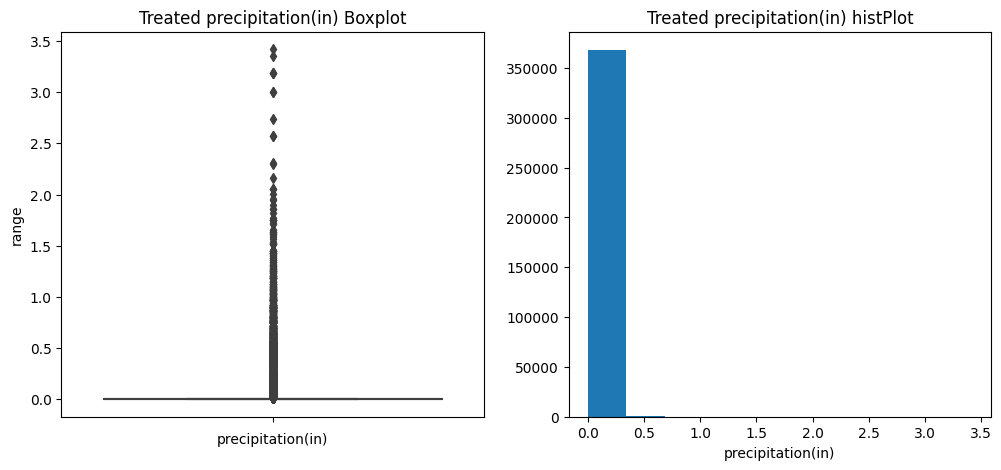

In [ ]:
plotBoxNhist(df2, 'precipitation(in)', 'Treated precipitation(in)')

**Observation**
- Can be clearly seen that the unsually high values have been removed.
- Such high values of precipitation occured for clear & cloudy days. These have been treated now

### 3. distance(mi)

We are trying to treat the outliers rather than simply dropping them.

We first try to treat the outliers with the median.

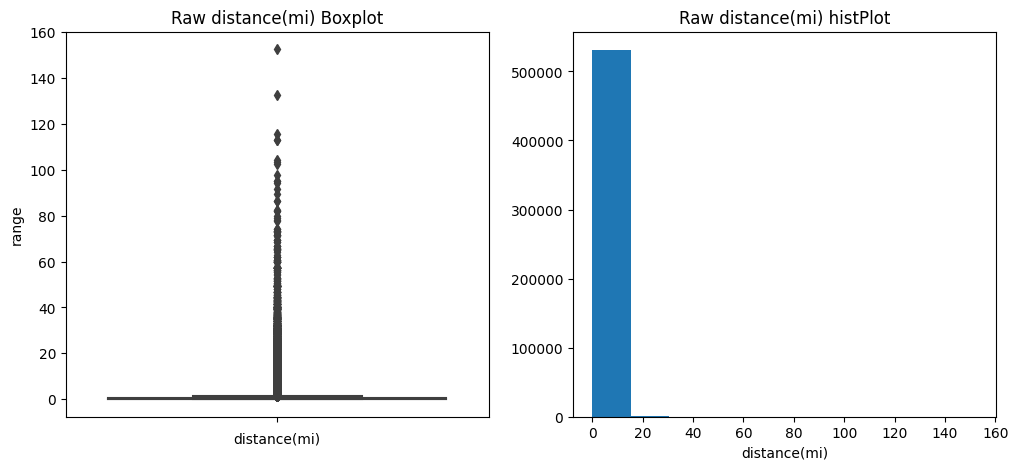

In [ ]:
plotBoxNhist(df2, 'distance(mi)', 'Raw distance(mi)')

In [ ]:
def getLB_UB(data):
        #percentile returns nan for data with nan values, so using nanpercentile
        q1 = np.nanpercentile(data, 25)
        q3 = np.nanpercentile(data, 75)
        IQR = q3-q1
        lower_bound = q1-(1.5*IQR)
        upper_bound = q3+(1.5*IQR)

        return (lower_bound, upper_bound)

def treat_outlier_with_median(x, col):
  lb, ub = getLB_UB(x[col])
  indices = x.loc[(x[col] < lb) | (ub < x[col]), col].index
  x.loc[indices, col] = x[col].median()

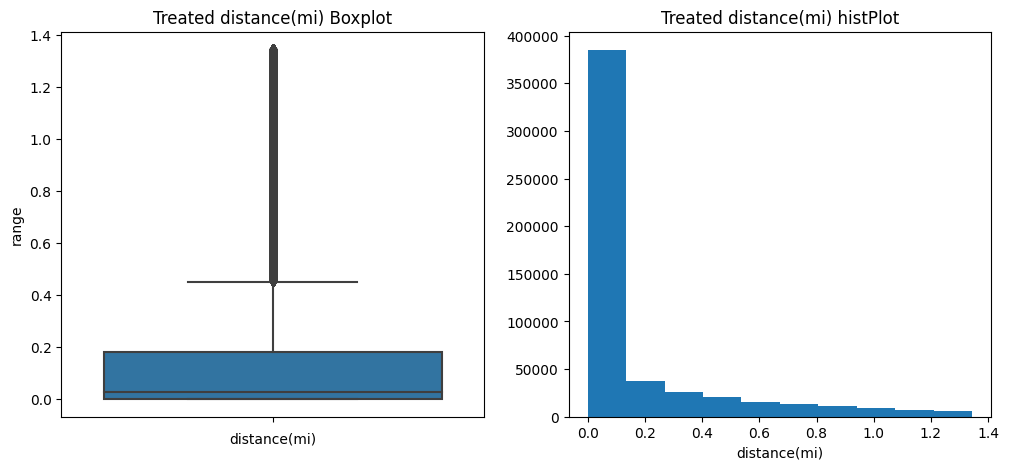

In [ ]:
treat_outlier_with_median(df2,"distance(mi)")
plotBoxNhist(df2, 'distance(mi)', 'Treated distance(mi)')

### 4. pressure(in)

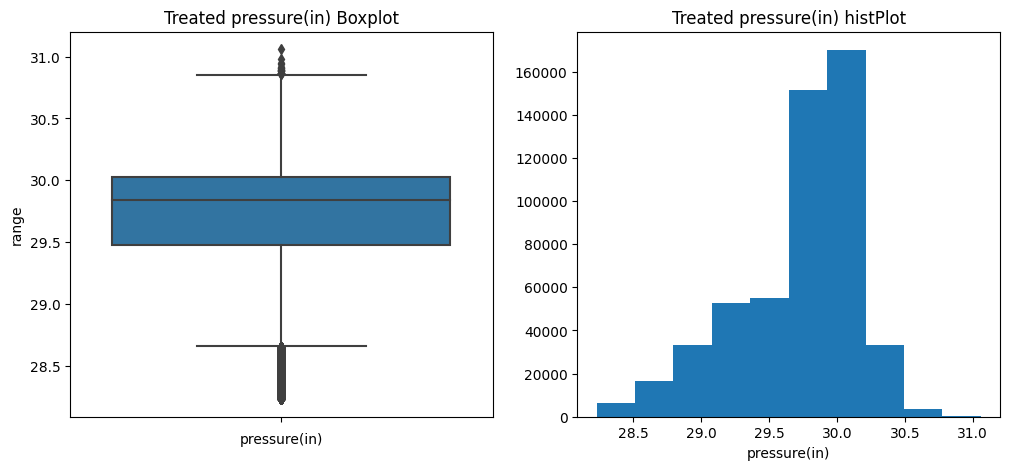

In [ ]:
treat_outlier_with_median(df2,"pressure(in)")
plotBoxNhist(df2, 'pressure(in)', 'Treated pressure(in)')

## Handling NaN values
- Check if nulls in a column can be better filled with respect to some other column
- else fill with mean, median or mode according to dtype of the column

**Quick Insight on the number of nulls per column**

- temperature(f)           :  12547
- wind_chill(f)            : 146003
- humidity(%)              :  13337
- pressure(in)             :  10816
- visibility(mi)           :  13684
- wind_direction           :  12845
- wind_speed(mph)          :  43746
- precipitation(in)        : 163956
- weather_condition        :  13602
- sunrise_sunset           :   2528

### wind_direction/ weather_condition /sunrise_sunset

In [ ]:
df2['wind_direction_mapped'].fillna(df2['wind_direction_mapped'].mode()[0], inplace = True)
df2['weather_bins_regex'].fillna(df2['weather_bins_regex'].mode()[0], inplace = True)
df2['sunrise_sunset'].fillna(df2['sunrise_sunset'].mode()[0], inplace = True)

### pressure(in)/ wind_speed(mph)

In [ ]:
df2['pressure(in)'].fillna(df2['pressure(in)'].mean(), inplace = True)
df2['wind_speed(mph)'].fillna(df2['wind_speed(mph)'].mean(), inplace = True)

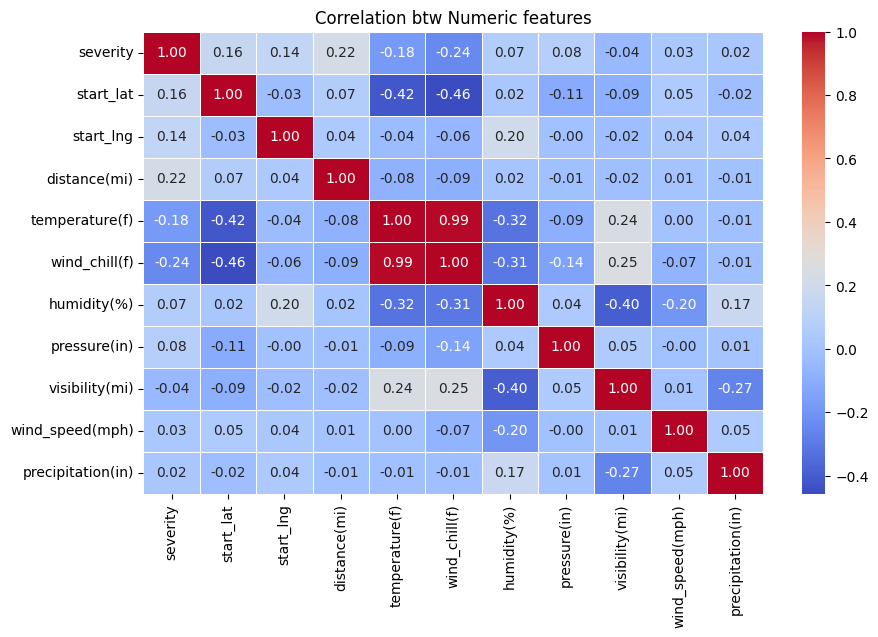

In [ ]:
numeric_values = df2.select_dtypes(exclude=['object', 'bool'])

sns.heatmap(numeric_values.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation btw Numeric features")
plt.show()

**Relationship Overview**
- Let's look at the correlation btw the numeric features.
- Since, if two or more features are highly correlated we can drop a few

### wind_chill(f)

**Observation**
- From the heatmap, we can observe that ***wind_chill(f) and temperature(f) are highly correlated***.







Text(0.5, 1.0, 'Wind Chill and Temperature relation')

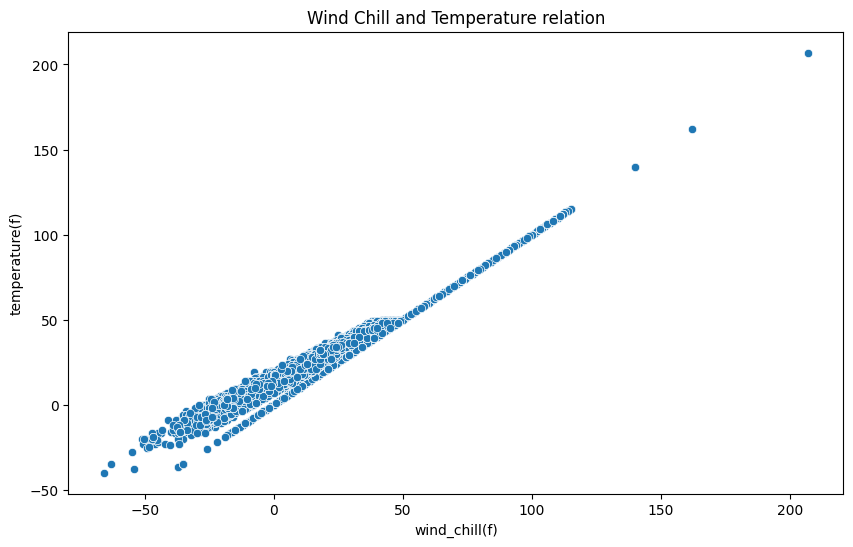

In [ ]:
# Here, wind_chill(f) and temperature(f) are plotted, we can observe that they are positively
# correlated.
sns.scatterplot(x='wind_chill(f)', y='temperature(f)', data=df2)
plt.xlabel('wind_chill(f)')
plt.ylabel('temperature(f)')
plt.title("Wind Chill and Temperature relation")

- Hence, ***dropping wind_chill(f)*** column.

In [ ]:
# Dropping wind_chill(f)

df2.drop(columns=['wind_chill(f)'], inplace=True)

### visibility(mi)

In [ ]:
visibility_nan_counts = df2['visibility(mi)'].isna().sum()
visibility_zero_counts = (df2['visibility(mi)'] == 0).sum()

print("Visibility(mi)\n")
print("NaN counts", visibility_nan_counts)
print("Zero counts", visibility_zero_counts)

Visibility(mi)

NaN counts 13684
Zero counts 492


*  Instead of filling the NaN values in visibility(mi) column by taking the mean of the values in the entire column, It is better to correlate visibility with weather conditions and fill NaN values accordingly.
*   Visibility is grouped by weather categories.


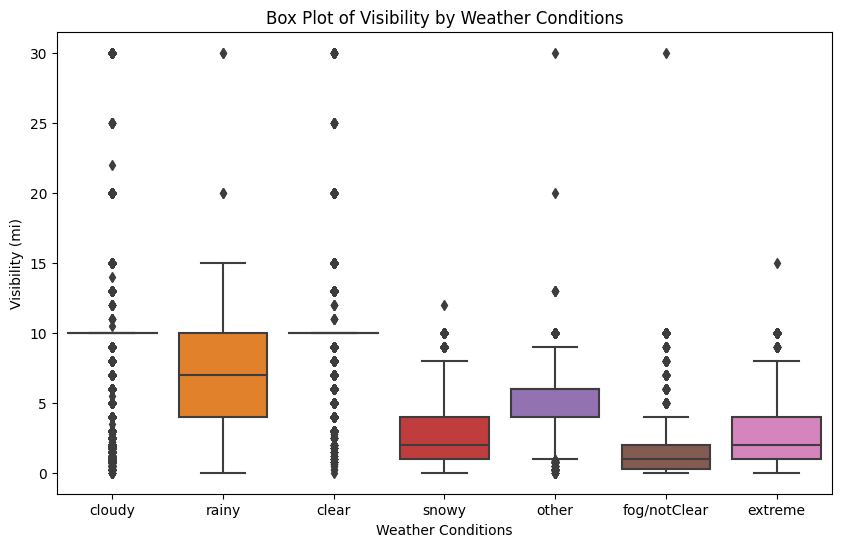

In [ ]:
sns.boxplot(x='weather_bins_regex', y='visibility(mi)', data=df2)
plt.title('Box Plot of Visibility by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Visibility (mi)')
plt.show()

In [ ]:
df2.groupby(["weather_bins_regex"])["visibility(mi)"].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,231008.0,9.847827,0.933040,0.0,10.00,10.0,10.0,30.0
cloudy,221046.0,9.547213,1.761071,0.0,10.00,10.0,10.0,30.0
extreme,4956.0,2.999104,2.760351,0.0,1.00,2.0,4.0,15.0
fog/notClear,7626.0,1.833003,2.631340,0.0,0.25,1.0,2.0,30.0
other,6832.0,5.546673,2.816541,0.0,4.00,6.0,6.0,30.0
rainy,37311.0,6.534972,3.193321,0.0,4.00,7.0,10.0,30.0
snowy,10531.0,2.801928,2.689696,0.0,1.00,2.0,4.0,12.0


Number of NaN values in visibility(mi) column based on weather condition.


In [ ]:
nan_counts = df2.groupby(["weather_bins_regex"])["visibility(mi)"].apply(lambda x: x.isna().sum())
print(nan_counts)

weather_bins_regex
clear             753
cloudy            553
extreme            12
fog/notClear        3
other           12283
rainy              66
snowy              14
Name: visibility(mi), dtype: int64


Filling NaN values in visibility(mi) column with mean of weather category to which the visibility(mi) record belongs to.

In [ ]:
# gets precipitation mean for each row based on weather condition
visibility_weather_category_means = df2.groupby('weather_bins_regex')['visibility(mi)'].transform('mean')
# Filling only the null values
df2['visibility(mi)'].fillna(visibility_weather_category_means, inplace = True)

### temperature(f)



In [ ]:
print("Temperature(f) NaN counts", df2['temperature(f)'].isna().sum())

Temperature(f) NaN counts 12506


In [ ]:
df2.groupby(["weather_bins_regex"])["temperature(f)"].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,230701.0,64.391571,18.862948,-35.0,53.00,67.0,78.0,162.0
cloudy,220944.0,62.647030,18.347316,-40.0,50.00,65.0,77.0,207.0
extreme,4948.0,61.710812,16.128085,-9.0,54.00,66.4,73.0,93.0
fog/notClear,7588.0,53.849407,15.111515,-38.0,44.00,54.0,64.0,113.0
other,8573.0,56.956538,21.824570,-37.0,39.20,60.8,73.0,115.0
rainy,37212.0,58.913708,14.081714,-4.0,48.00,57.9,71.0,104.0
snowy,10522.0,24.768200,8.634653,-20.0,20.15,27.0,31.0,75.0


In [ ]:
temperature_nan_counts = df2.groupby(["weather_bins_regex"])["temperature(f)"].apply(lambda x: x.isna().sum())
print("Temp Nans per weather condition\n")
print(temperature_nan_counts)

Temp Nans per weather condition

weather_bins_regex
clear            1060
cloudy            655
extreme            20
fog/notClear       41
other           10542
rainy             165
snowy              23
Name: temperature(f), dtype: int64


In [ ]:
temperature_weather_category_means = df2.groupby('weather_bins_regex')['temperature(f)'].transform('mean')
df2['temperature(f)'].fillna(temperature_weather_category_means, inplace = True)

### precipitation(in)

In [ ]:
precipitation_nan_counts = df2['precipitation(in)'].isna().sum()
print("NaN precipitation counts", precipitation_nan_counts)

NaN precipitation counts 163612


In [ ]:
df2['precipitation(in)'].describe()

count    369382.000000
mean          0.007815
std           0.050710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.420000
Name: precipitation(in), dtype: float64

**Observation**
- we have ~1.63L null in precipitation col, a very large amount
- cannot simply fill with mean, since it's very small


In [ ]:
df2.groupby(["weather_bins_regex"])["precipitation(in)"].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,165996.0,0.000157,0.006181,0.0,0.00,0.00,0.00,0.80
cloudy,142328.0,0.002169,0.022048,0.0,0.00,0.00,0.00,1.37
extreme,4756.0,0.174708,0.271508,0.0,0.02,0.09,0.22,3.42
fog/notClear,6202.0,0.001421,0.015601,0.0,0.00,0.00,0.00,0.61
other,5693.0,0.006636,0.035411,0.0,0.00,0.00,0.00,1.06
rainy,34825.0,0.045214,0.094730,0.0,0.00,0.01,0.05,1.96
snowy,9582.0,0.010437,0.026811,0.0,0.00,0.00,0.01,1.43


In [ ]:
precipitation_weather_category_means = df2.groupby('weather_bins_regex')['precipitation(in)'].transform('mean')
df2['precipitation(in)'].fillna(precipitation_weather_category_means, inplace = True)

### humidity(%)

In [ ]:
print("humidity(%) NaN counts: ", df2['humidity(%)'].isna().sum())

# calculate mean and fill the NaN values in humidity
df2['humidity(%)'].fillna(df2['humidity(%)'].mean(), inplace = True)

humidity(%) NaN counts:  13296


# Feature Extraction

In [ ]:
df3 = df2.copy()

Extracting features `duration(min)`, `year`, `month`, `day`, `hour`, `weekday` from `start_time` and `end_time`

In [ ]:
df3['start_time'] = pd.to_datetime(df2['start_time'])
df3['end_time'] = pd.to_datetime(df2['end_time'])
df3['duration(min)'] = (df3['end_time'] - df3['start_time']).dt.total_seconds() / 60

df3['year'] = df3['start_time'].dt.year
df3['month'] = df3['start_time'].dt.month
df3['day'] = df3['start_time'].dt.day
df3['hour'] = df3['start_time'].dt.hour
df3['weekday'] = df3['start_time'].dt.weekday

df3['day'] = df3['day'].astype(object)
df3['weekday'] = df3['weekday'].astype(object).apply(lambda val: calendar.day_name[val])
df3['month'] = df3['month'].astype(object).apply(lambda val: calendar.month_name[val])

In [ ]:
# Create time bins
bins = [0, 6, 9, 13, 17, 21, 24]

# Create labels for the bins
labels = ['Midnight', '6AM-9AM', '9AM-1PM', '1PM-5PM', '5PM-9PM', '9PM-12AM']

# Bin the start_time column
df3['time_slot'] = pd.cut(df3['hour'], bins=bins, labels=labels)

In [ ]:
df3['time_slot'].value_counts()

1PM-5PM     137472
6AM-9AM     105380
9AM-1PM      95535
Midnight     81643
5PM-9PM      81341
9PM-12AM     22198
Name: time_slot, dtype: int64

Extracting categorical columns:
`visibility(mi)_bin` `precipitation(in)_bin` `temperature()_bin` `pressure(in)bin` `wind_speed(mph)_bin` `distance(mi)_bin` `humidity(%)_bin`

from numerical features:
`visibility(mi)`
`precipitation(in)`
`temperature(f)`
`pressure(in)`
`wind_speed(mph)`
`distance(mi)`
`humidity(%)`


using quantiles.

In [ ]:
def create_bins_numerical_features(data, column_name):
    q25_value = data[column_name].quantile(0.25)
    q50_value = data[column_name].quantile(0.5)
    q75_value = data[column_name].quantile(0.75)

    data[column_name + '_bin'] = 'very_low'
    data.loc[data[column_name] > q25_value, column_name + '_bin'] = 'low'
    data.loc[data[column_name] > q50_value, column_name + '_bin'] = 'medium'
    data.loc[data[column_name] > q75_value, column_name + '_bin'] = 'high'

    return data

In [ ]:
# Creating categorical bins for numerical features using quantiles
bin_columns = ['visibility(mi)', 'precipitation(in)', 'temperature(f)', 'pressure(in)',
                'wind_speed(mph)', 'distance(mi)', 'humidity(%)']

for column in bin_columns:
    create_bins_numerical_features(df3, column)

# EDA - II

Text(0.5, 1.0, 'Severity vs Time_Slot')

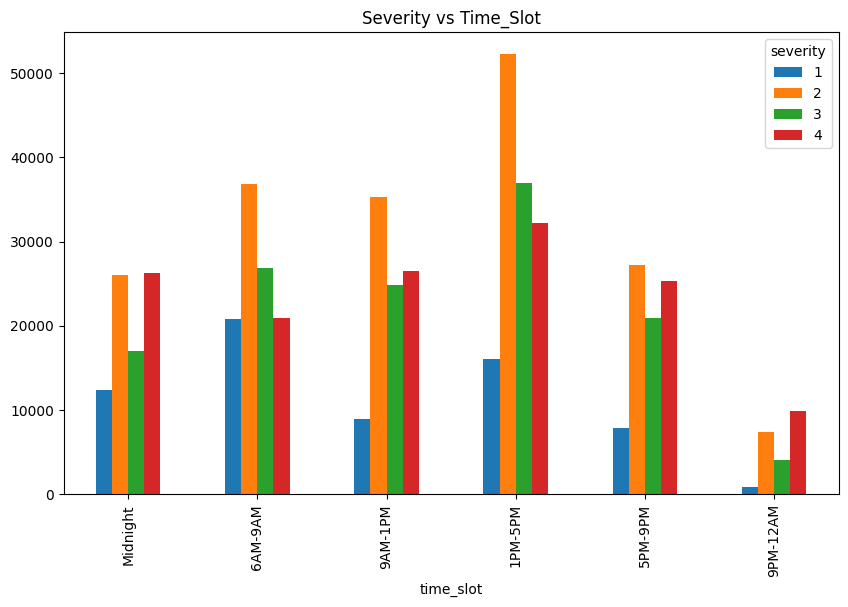

In [ ]:
#plotting time_slot and severity of accidents
time_vs_severity=pd.crosstab(df3['time_slot'],df3['severity'])
time_vs_severity.plot(kind='bar')
plt.title('Severity vs Time_Slot')

**Observation**
- A little intuitive
    - Higher number of accidents during working/commute hours
    - significantly less accidents after 9 & through the midnight

<ipython-input-161-bc2815b71054>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sns.heatmap(df3[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
<ipython-input-161-bc2815b71054>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df3[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)


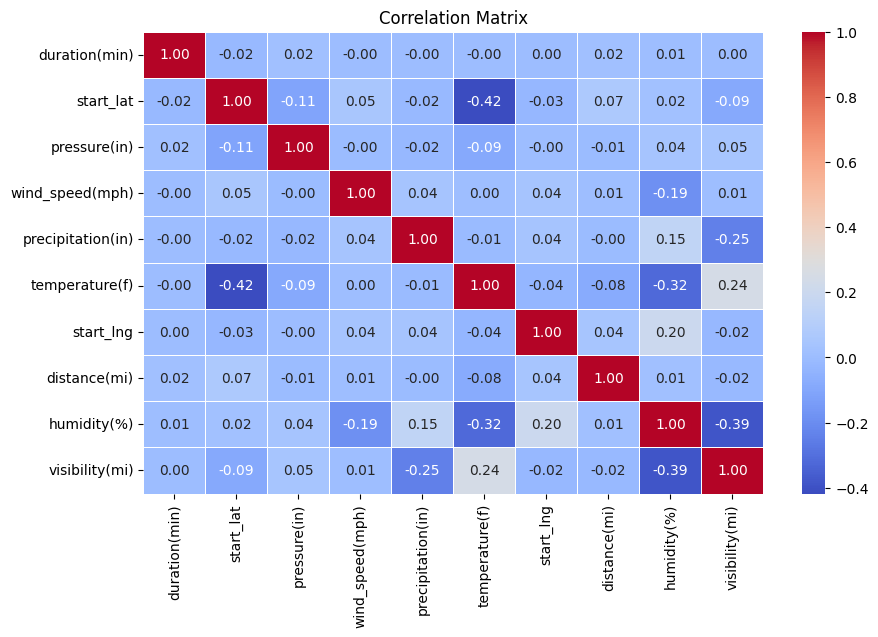

In [ ]:
#Distance of the accident vs Time duration
categorical_cols = df3.select_dtypes(['bool', 'object','int']).columns
numeric_cols = set(df3.columns) - set(categorical_cols)
sns.heatmap(df3[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

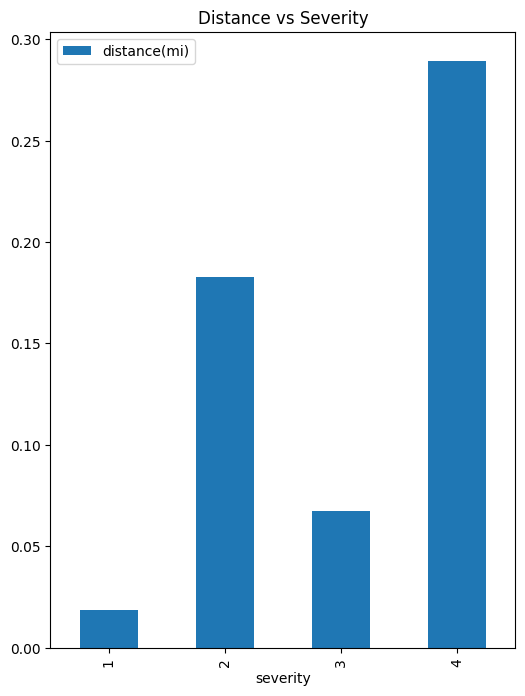

In [ ]:
#Distance of the accident vs severity
distance_vs_severity=pd.DataFrame(df3.groupby(['severity'])['distance(mi)'].mean())
distance_vs_severity.plot.bar(figsize=(6,8))
plt.title('Distance vs Severity')
plt.show()

**Observation**
- The mean road distance affected by an accident seems to be higher for accidents with higher severity

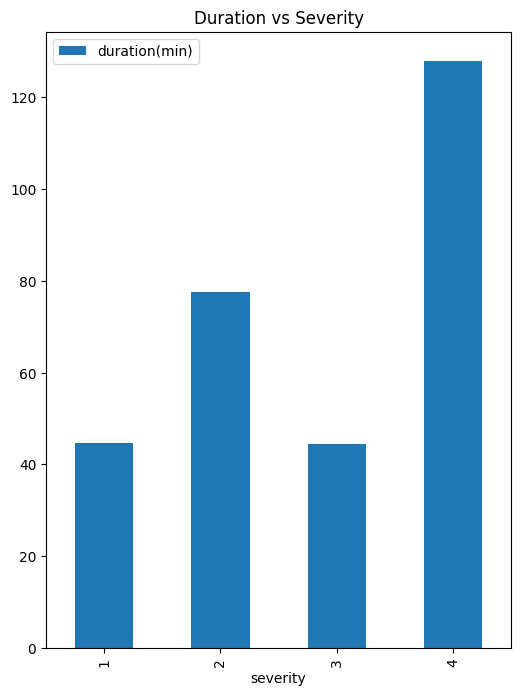

In [ ]:
duration_vs_severity=pd.DataFrame(df3.groupby(['severity'])['duration(min)'].median())
duration_vs_severity.plot.bar(figsize=(6,8))
plt.title('Duration vs Severity')
plt.show()

**Observation**
- Nothing note worthy

Text(0.5, 1.0, 'Severity vs Weather Condition')

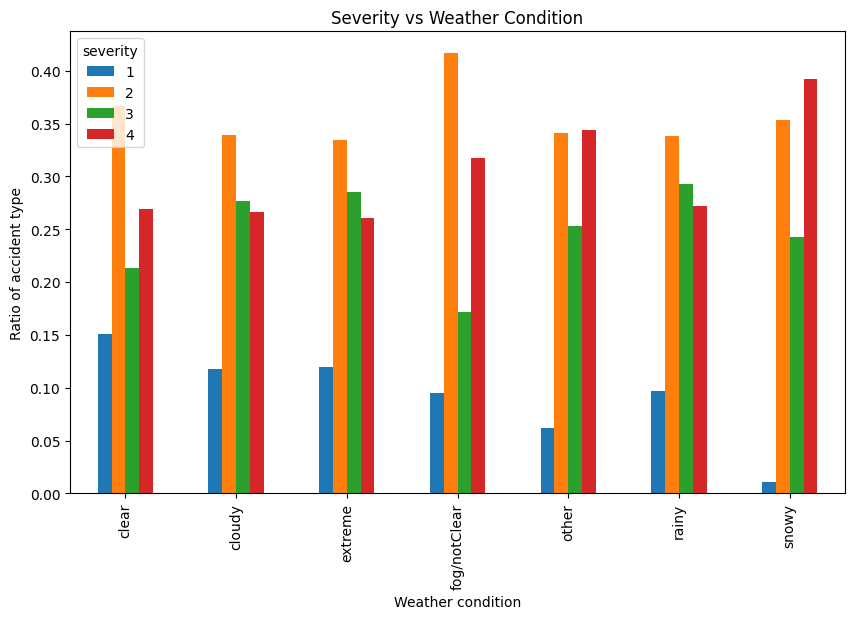

In [ ]:
#weather_conditions vs severity
weather_vs_severity=pd.crosstab(df3['weather_bins_regex'],df3['severity'])
weather_vs_severity.div(weather_vs_severity.sum(axis=1),axis=0).plot(kind='bar')
plt.xlabel("Weather condition")
plt.ylabel("Ratio of accident type")
plt.title('Severity vs Weather Condition')

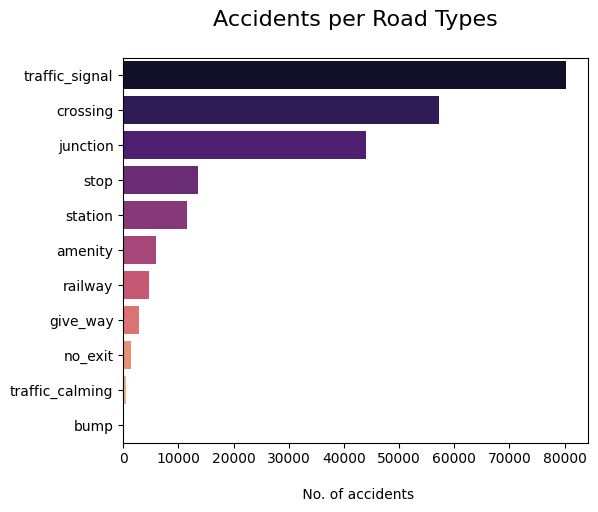

In [ ]:
#Road Type Analysis
road_types = ["amenity", "bump", "crossing", "give_way", "junction", "no_exit", "railway","station", "stop","traffic_calming", "traffic_signal"]

df_roads = df3[road_types].sum().sort_values(ascending=False)
df_roads.tail()

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=df_roads.values, y=df_roads.index, palette='magma')
plt.title("Accidents per Road Types\n", fontsize=16)
plt.xlabel("\n No. of accidents")

plt.show()

**Observation**
- Top 3 road types with most accidents are
    - traffic_signal
    - crossing
    - junction

- Let's look at the top 3 with respect to severity

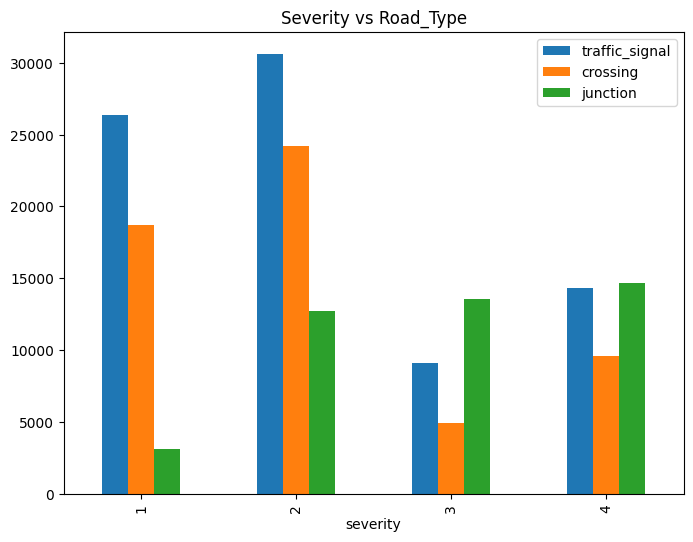

In [ ]:
df_ts = pd.DataFrame(df.groupby(['severity'])[['traffic_signal','crossing','junction']].sum())
df_ts.plot.bar(figsize=(8,6))
plt.title('Severity vs Road_Type')
plt.show()

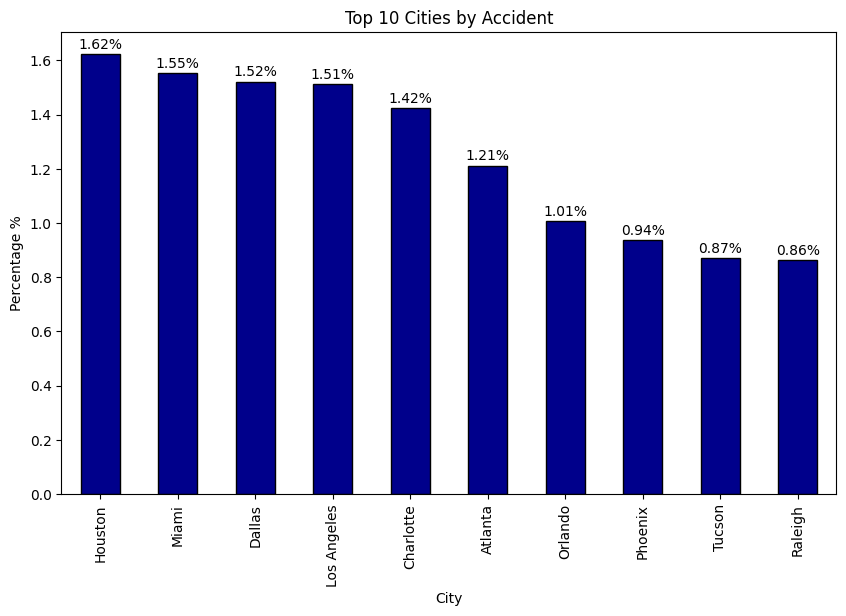

In [ ]:
#Cities
top_10_cities_by_accident=df3['city'].value_counts().nlargest(10)

percentage = (top_10_cities_by_accident / len(df)) * 100

percentage.plot(kind='bar', color='darkblue', edgecolor='black')

plt.title('Top 10 Cities by Accident')
plt.xlabel('City')
plt.ylabel('Percentage %')

for i, value in enumerate(percentage):
    plt.text(i, value + 0.02, f'{value:.2f}%', ha='center')

plt.show()


Text(0.5, 1.0, 'Top 10 States by accident percentage')

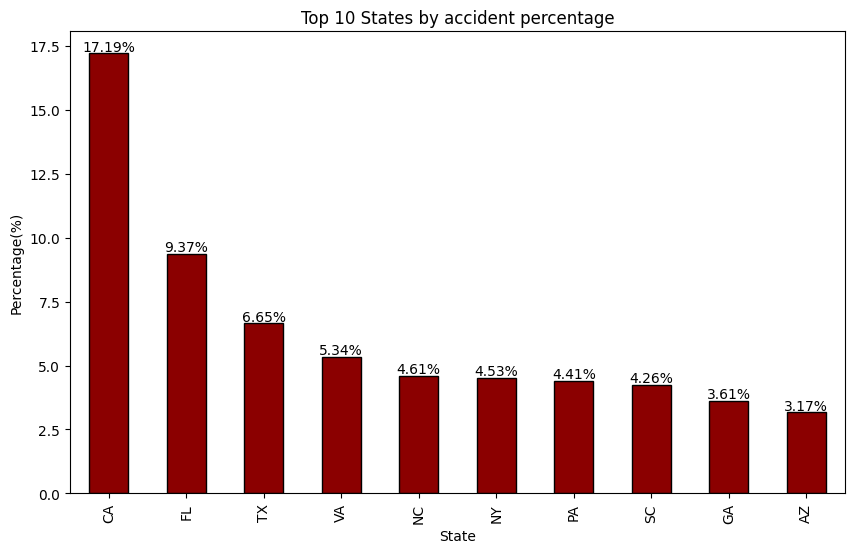

In [ ]:
# States
severity_by_state = df3.groupby('state')['severity'].count().sort_values(ascending=False)
top_10_severity_by_state = severity_by_state.head(10)

top_10_state_names = [
    "California",
    "Florida",
    "Texas",
    "Virginia",
    "North Carolina",
    "New York",
    "Pennsylvania",
    "South Carolina",
    "Georgia",
    "Arizona"
]


percentage = (top_10_severity_by_state / len(df)) * 100
percentage.set_axis(top_10_state_names)

percentage.plot(kind='bar', color='darkred', edgecolor='black')

for i, value in enumerate(percentage):
    plt.text(i, value + 0.1, f'{value:.2f}%', ha='center')

plt.xlabel('State')
plt.ylabel('Percentage(%)')
plt.title('Top 10 States by accident percentage')


**Time Based Analysis**

Text(0, 0.5, 'count')

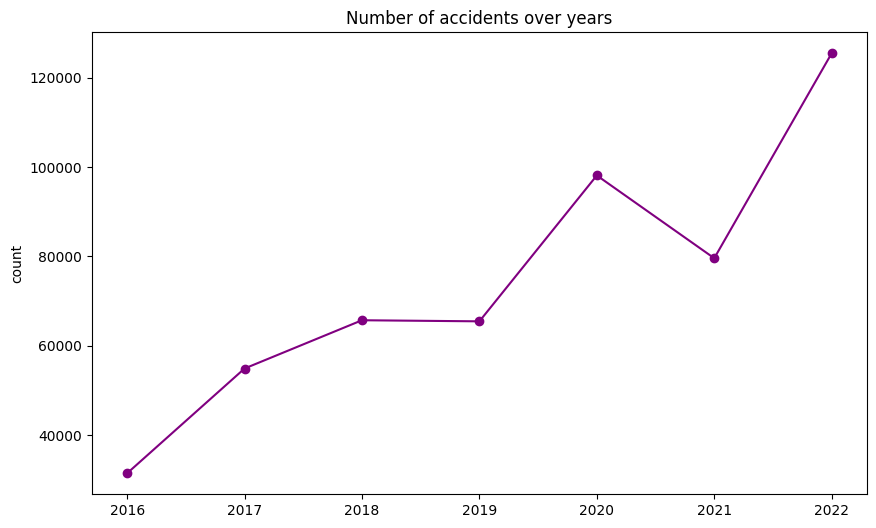

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]

df_not_2023 = df3.loc[df3['year'] != 2023, :]
df_not_2023['year'].value_counts().sort_index().plot(marker='o', color='purple')
plt.title("Number of accidents over years")
plt.ylabel('count')

**Observation**
- The accidents have increased gradually over the years
- Drop in the number of accidents in 2021 could have been because of COVID-19

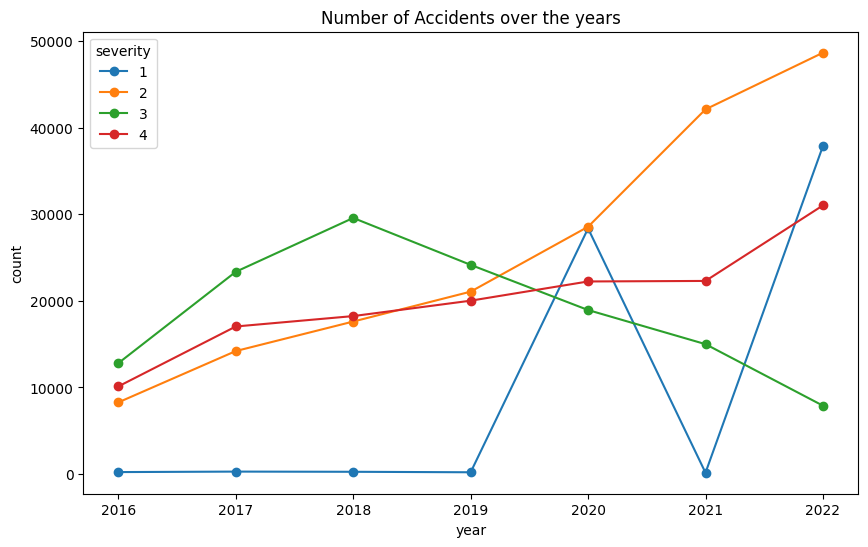

In [ ]:
year_vs_severity = pd.crosstab(df_not_2023['year'], df_not_2023['severity'])
year_vs_severity.plot(marker='o')
plt.title("Number of Accidents over the years")
plt.ylabel('count')
plt.show()

In [ ]:
min_yr, max_yr = min(year_vs_severity.index), max(year_vs_severity.index)
print(f"Percentage Changes in the number of accidents from {min_yr} to {max_yr}")
for class_ in year_vs_severity.columns:
    n_acc_min_yr = year_vs_severity.loc[min_yr,class_]
    n_acc_max_yr = year_vs_severity.loc[max_yr,class_]
    print("class",class_,"->",round((n_acc_max_yr-n_acc_min_yr)/n_acc_min_yr * 100, 2),"%")

Percentage Changes in the number of accidents from 2016 to 2022
class 1 -> 16732.44 %
class 2 -> 487.77 %
class 3 -> -38.36 %
class 4 -> 206.51 %


Text(0, 0.5, 'count')

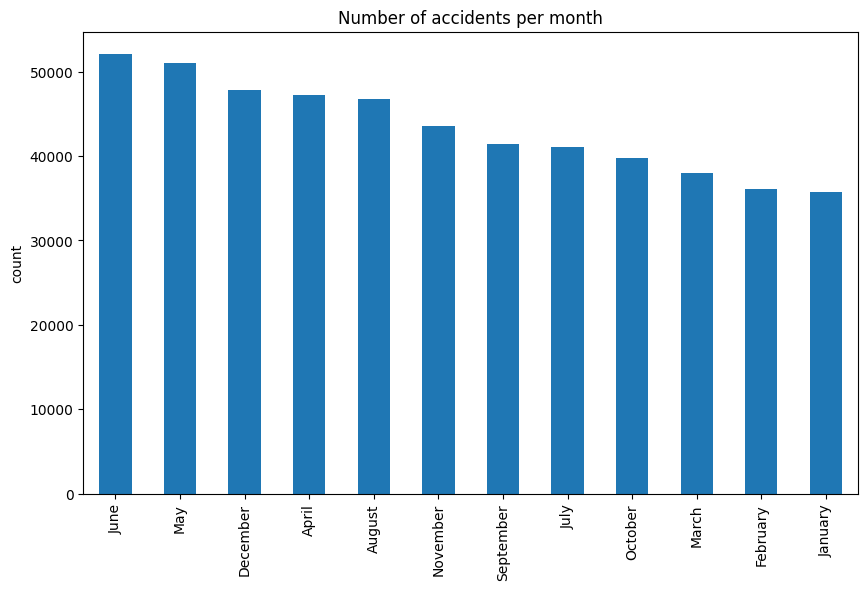

In [ ]:
df_not_2023['month'].value_counts().plot(kind = 'bar')
plt.title("Number of accidents per month")
plt.ylabel('count')

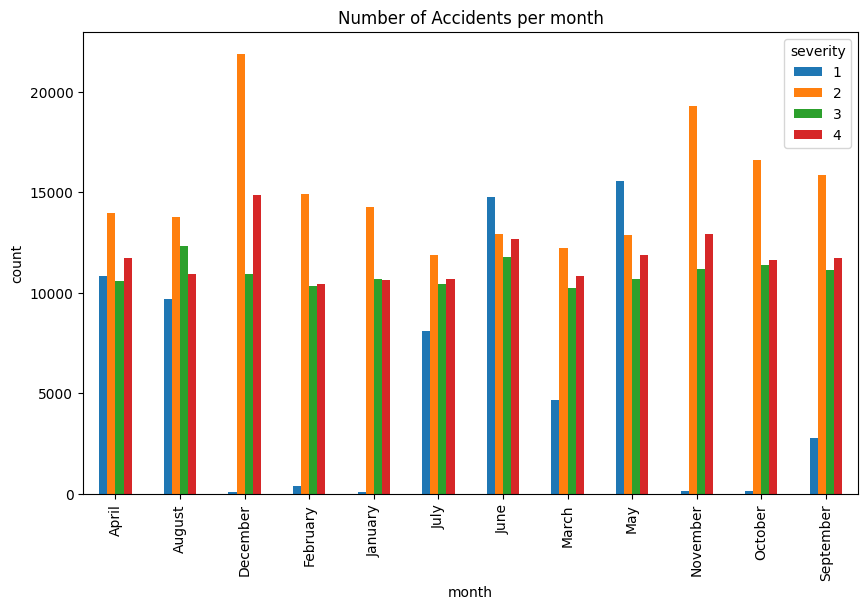

In [ ]:
month_vs_severity = pd.crosstab(df_not_2023['month'], df_not_2023['severity'])
month_vs_severity.plot(kind='bar')
plt.title("Number of Accidents per month")
plt.ylabel('count')
plt.show()

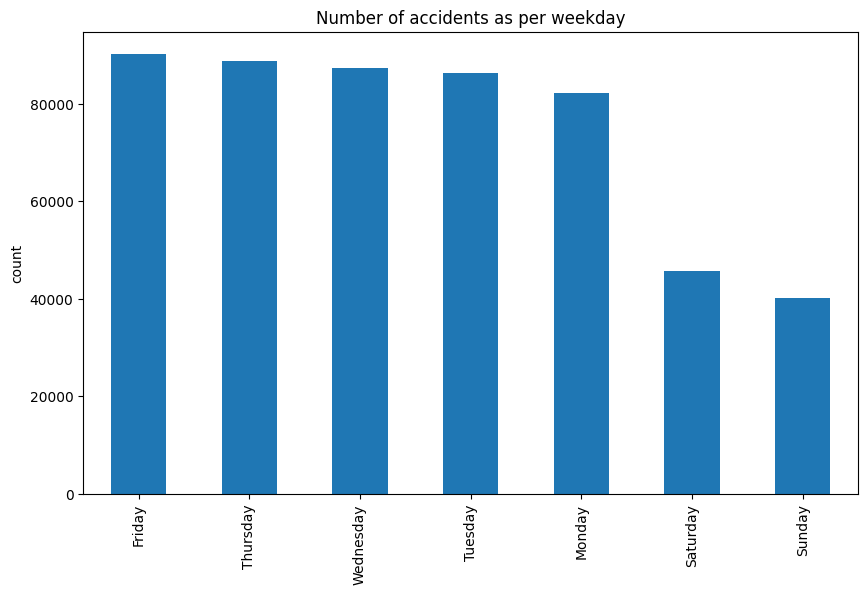

In [ ]:
df_not_2023['weekday'].value_counts().plot(kind = 'bar')
plt.title("Number of accidents as per weekday")
plt.ylabel('count')
plt.show()

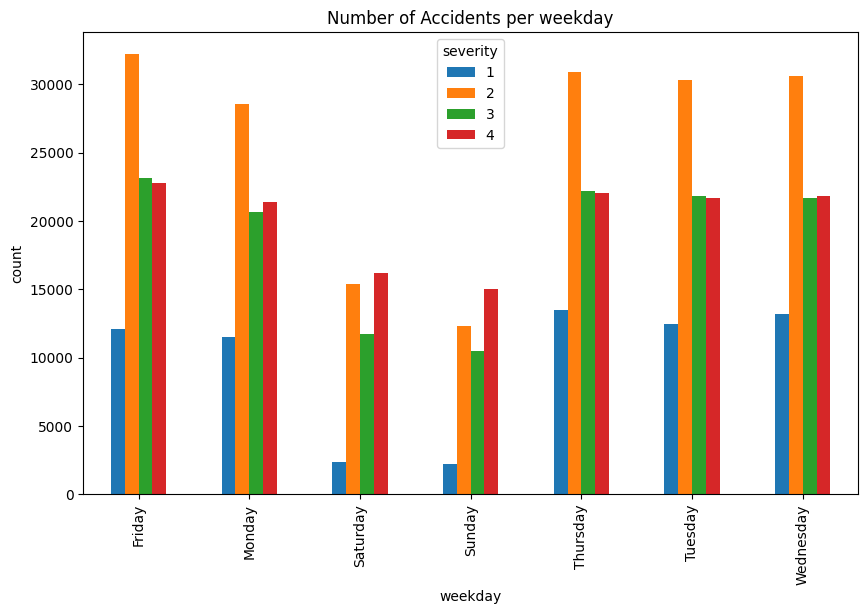

In [ ]:
weekday_vs_severity = pd.crosstab(df_not_2023['weekday'], df_not_2023['severity'])
weekday_vs_severity.plot(kind='bar')
plt.title("Number of Accidents per weekday")
plt.ylabel('count')
plt.show()

**Observation**
- Weekend actually has less number of accidents, maybe because people are less likely to travel

# Building pipelines

## Classes for pipelines

In [ ]:
class FeatureExtractor():
    def fit(self, x, y=None):
        return self

    def create_bins_numerical_features(self, data, column_name):
        q25_value = data[column_name].quantile(0.25)
        q50_value = data[column_name].quantile(0.5)
        q75_value = data[column_name].quantile(0.75)

        data[column_name + '_bin'] = 'very_low'
        data.loc[data[column_name] > q25_value, column_name + '_bin'] = 'low'
        data.loc[data[column_name] > q50_value, column_name + '_bin'] = 'medium'
        data.loc[data[column_name] > q75_value, column_name + '_bin'] = 'high'

        return data

    def transform(self, x):
        data = x.copy()
        data.columns = data.columns.map(lambda col: col.lower())

        data['start_time'] = pd.to_datetime(data['start_time'])
        data['month'] = data['start_time'].dt.month
        data['day'] = data['start_time'].dt.day
        data['hour'] = data['start_time'].dt.hour
        data['weekday'] = np.array(data['start_time'].dt.weekday, dtype='int64')

        data['day'] = data['day'].astype(object)
        data['weekday'] = data['weekday'].astype(object).apply(lambda val: calendar.day_name[val])
        data['month'] = data['month'].astype(object).apply(lambda val: calendar.month_name[val])

        # Create time bins
        bins = [0, 6, 9, 13, 17, 21, 24]
        # Create labels for the bins
        labels = ['Midnight', '6AM-9AM', '9AM-1PM', '1PM-5PM', '5PM-9PM', '9PM-12AM']
        # Bin the start_time column
        data['time_slot'] = pd.cut(data['hour'], bins=bins, labels=labels, include_lowest=True, right=False)

        # Creating categorical bins for numerical features
        bin_columns = ['visibility(mi)', 'precipitation(in)', 'temperature(f)', 'pressure(in)',
                       'wind_speed(mph)', 'distance(mi)', 'humidity(%)']

        for column in bin_columns:
            self.create_bins_numerical_features(data, column)

        bin_columns.append('start_time')
        data.drop(columns=bin_columns, inplace=True)
        return data

In [ ]:
class PredictionColSelector():
    def __init__(self):
        pass

    def fit(self, x, y=None):

        self.prediction_features = ['distance(mi)','humidity(%)','pressure(in)','wind_direction',
                       'wind_speed(mph)','weather_condition','amenity','bump','crossing','give_way',
                       'junction','no_exit','railway','station','stop','traffic_calming','traffic_signal','sunrise_sunset',
                       'severity', 'month', 'day', 'weekday', 'time_slot', 'visibility(mi)', 'precipitation(in)', 'temperature(f)', 'start_time']
        return self

    def transform(self, x):
        #convert all the column names to lower case
        x.columns = x.columns.map(lambda col: col.lower())

        #select only the features needed for prediction
        cols_of_interest = set(x.columns).intersection(self.prediction_features)
        x = x.loc[:, list(cols_of_interest)]

        return x

In [ ]:
class BinNMapper():
    def __init__(self):
        pass

    def fit(self, x, y=None):
        self.weather_patterns = [
            ('clear', re.compile('fair|clear',re.IGNORECASE)),
            ('cloudy', re.compile('cloud|overcast',re.IGNORECASE)),
            ('fog/notClear', re.compile('fog|sand|dust|smok(e|y)',re.IGNORECASE)),
            ('extreme', re.compile('heavy|heavily|hail|t-storm|tornado', re.IGNORECASE)), # SHOULD NOT CONTAIN word LIGHT
            ('snowy', re.compile('snow', re.IGNORECASE)),
            ('rainy', re.compile(r'rain|drizzl(e|ing)|sleet|thunder|winter|drop|shower', re.IGNORECASE))
        ]

        self.wind_mappings = {
            'south': ['south', 's'],
            'north': ['north', 'n'],
            'east': ['east', 'e'],
            'west': ['west', 'w'],
            'var': ['variable', 'var']
        }

        return self

    def _map_weather_condition(self, weather):
        for label, pattern in self.weather_patterns:
            if pattern.search(str(weather)):
                return label.lower()
        return "other"

    def _map_wind_dir(self, wind_dir):
        wind_dir = str(wind_dir).lower()
        for label, vals in self.wind_mappings.items():
            if wind_dir in vals:
                return label.lower()
        return wind_dir

    def transform(self, x):
        data = x.copy()
        #Should make sure we do not transform null values

        # Bin weather_condition into appropriate category
        data['weather_condition'] = data.loc[data['weather_condition'].notnull() , 'weather_condition'].apply(self._map_weather_condition)

        # Standardize wind_dir value
        data.loc[:,'wind_direction'] = data.loc[data['wind_direction'].notnull(), 'wind_direction'].apply(self._map_wind_dir)

        return data


In [ ]:
class TreatOutliers():
    def fit(self, x, y=None):
        return self

    def _getLB_UB(self, data):
        #percentile returns nan for data with nan values, so using nanpercentile
        q1 = np.nanpercentile(data, 25)
        q3 = np.nanpercentile(data, 75)
        IQR = q3-q1
        lower_bound = q1-(1.5*IQR)
        upper_bound = q3+(1.5*IQR)

        return (lower_bound, upper_bound)

    def _treat_outlier_with_median(self, x, col):
        lb, ub = self._getLB_UB(x[col])
        indices = x.loc[(x[col] < lb) | (ub < x[col]), col].index
        x.loc[indices, col] = x[col].median()

    def replace_with_median(self, x):
        data = x.copy()

        cols = ['precipitation(in)', 'pressure(in)', 'distance(mi)', 'visibility(mi)']
        for col in cols:
            self._treat_outlier_with_median(data, col)

        return data

    def sophisticated(self, x):
        data = x.copy()

        #precipitation(Removing few & treating a few)
        PRECIPI_UPPER_LIMIT = np.nanpercentile(data['precipitation(in)'], 99.98)
        precipi_clear_outlier_indices = data[(data['weather_condition'].isin(['clear', 'other'])) & (data['precipitation(in)'] > PRECIPI_UPPER_LIMIT)].index
        data = data[~data.index.isin(precipi_clear_outlier_indices)]

        precipi_cloudy_outlier_indices = data[(data['weather_condition'] == 'cloudy') & (data['precipitation(in)'] > PRECIPI_UPPER_LIMIT)].index
        data.loc[data.index.isin(precipi_cloudy_outlier_indices),'precipitation(in)'] = data[data['weather_condition'] == 'cloudy']['precipitation(in)'].mean()

        #Visibility (Removing outliers)
        VISIBILITY_UPPER_LIMIT = np.nanpercentile(data['visibility(mi)'], 99.98)
        visi_out_idx = data[data['visibility(mi)'] > VISIBILITY_UPPER_LIMIT]
        data = data[~data.index.isin(visi_out_idx.index)]

        #distance(mi)
        data['distance(mi)'] = winsorize(data['distance(mi)'], (0.00, 0.005))

        #pressure(in)
        data['pressure(in)'] = winsorize(data['pressure(in)'], (0.005, 0))

        # Z-score based trimming outliers
        """
        col = 'pressure(in)'
        mean = transformed_df[col].mean()
        std = transformed_df[col].std()

        LL = mean - 3*std
        UL = mean + 3*std

        trans_col = transformed_df[(transformed_df[col] > LL) & (transformed_df[col] < UL)][col]
        # plt.boxplot(trans_col)
        transformed_df.shape[0] - trans_col.shape[0]
        """

        return data

In [ ]:
class TreatNulls():

    def fit(self, x, y=None):
        self.custom_repl_cols = ['precipitation(in)', 'visibility(mi)', 'temperature(f)']
        self.mean_repl_cols = ['humidity(%)','pressure(in)','wind_speed(mph)']
        self.mode_repl_cols = ['wind_direction','weather_condition','sunrise_sunset']

        self.custom_repl = x.groupby('weather_condition')[self.custom_repl_cols].mean()

        self.mean_repl = {}
        for col in self.mean_repl_cols:
            self.mean_repl[col] = np.round(x[col].mean(), 2)

        self.mode_repl = {}
        for col in self.mode_repl_cols:
            self.mode_repl[col] = x[col].mode()[0]

        return self

    def transform(self, x):
        data = x.copy()

        #Imputing nulls in numeric cols with mean
        for col in self.mean_repl_cols:
            data[col].fillna(self.mean_repl[col], inplace=True)

        #Imputing nulls in categorical cols with mode
        for col in self.mode_repl_cols:
            data[col].fillna(self.mode_repl[col], inplace=True)

        #Custom Imputing using weather_condition
        unique_weather_conds = data['weather_condition'].unique()

        for weather in unique_weather_conds:
            for col in self.custom_repl_cols:
                data[col].fillna(self.custom_repl.loc[weather, col], inplace=True)

        return data

## Transformation 0: Preprocessing Pipelines
- Replacing outliers with median, so that we do not loose data
- Imputing nulls with mean and mode
- Applying, StandardScaler & OrdinalEncoder

In [ ]:
selector_n_binner_0 = Pipeline(
    steps=[
        ('colSelector', PredictionColSelector()),
        ('binNmapper', BinNMapper()),
    ]
)

num_transformer_0 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer_0 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

processor_trans_0 = ColumnTransformer(
    transformers=[
        ('num', num_transformer_0, make_column_selector(dtype_exclude=['bool', 'object', 'category'])), #only non-cat cols
        ('cat', cat_transformer_0, make_column_selector(dtype_include=['bool', 'object', 'category'])), #only cat cols should be passed
    ]
)

## Transformation 1: Preprocessing Pipelines
- Careful treatment of nulls and outliers
- Applying the things discovered during preprocessing step
- Outlier cannot be included in the pipeline but is considered as a part of this transformation

In [ ]:
ext_sel_n_binner_1 = Pipeline(
    steps=[
        ('colSelector', PredictionColSelector()),
        ('binNmapper', BinNMapper()),
    ]
)

num_transformer_1 = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

cat_transformer_1 = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

processor_trans_1 = ColumnTransformer(
    transformers=[
        ('num', num_transformer_1, make_column_selector(dtype_exclude=['bool', 'object', 'category'])), #only num
        ('cat', cat_transformer_1, make_column_selector(dtype_include=['bool', 'object', 'category'])), #only cat cols should be passed
    ]
)

**Creating final Pipelines with Prediction Models**

In [ ]:
## FINAL PIPELINES USING BASIC TRANSFORMATION (0)
pipe_trans_0 = processor_trans_0

## FINAL PIPELINES USING TRANSFORMATION 1

pipe_trans_1 = Pipeline(steps=[
    ('Imputer', TreatNulls()),
    ('FeatureExtractor', FeatureExtractor()),
    ('processor', processor_trans_1)
    ])

**RUN THROUGH the transformations(preprocessing)**
- Transformation 0
    1. *selector_n_binner_0.fit_tranform*: selects prediction features & performs binning & mapping
    2. *TreatOutlier.replace_with_median*: treat outliers
    3. *pipe_trans_0.fit_tranform*: Fill Nulls, scale & encode

- Transformation 1
    1. *ext_sel_n_binner_1.fit_transform:* <br>
        a. performs extraction of features<br>
        b. selects the columns<br>
        c. perform binning and mapping
    2. *TreatOutliers.sophisticated*
    3. *pipe_trans_1.fit_transform:* <br>
        a. TreatNulls.fit_transform<br>
        b. processor_trans_1: Scaling & encoding


#Evaluation Metric definitions

In [ ]:
def classification_task( model, x_train, y_train, x_test, y_test, y_pred, model_name):

    performance_df = pd.DataFrame(
        {'Train_Score':model.score(x_train, y_train),
         "Test_Score":model.score(x_test, y_test),
         "Precision_Score":precision_score(y_test, y_pred, average='weighted'),
         "Recall_Score":recall_score(y_test, y_pred, average='weighted'),
         "F1_Score":f1_score(y_test, y_pred, average='weighted') ,
         "accuracy":accuracy_score(y_test, y_pred)},
        index=[model_name])

    return performance_df

In [ ]:
# Plot precision-recall curves for each class
def plot_precision_recall_curve(x_test, y_test, model, model_name, classes = [1,2,3,4]):
    plt.figure(figsize=(8, 6))
    y_test_bin = label_binarize(y_test, classes=classes)
    for i in range(len(model.classes_)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:,i], model.predict_proba(x_test)[:, i])
        auc_score = auc(recall, precision)
        plt.step(recall, precision, where='post', label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name}: Precision-Recall Curve for Each Severity class')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='center left')
    plt.show()

# Prediction

In [ ]:
data = df.copy()

## Transformation 0



In [ ]:
data_trans_0 = selector_n_binner_0.fit_transform(data)
data_trans_0 = TreatOutliers().replace_with_median(data)

In [ ]:
X_trans_0 = data_trans_0.drop('severity', axis=1)
X_trans_0 = pipe_trans_0.fit_transform(X_trans_0) #Applying transformation

y_trans_0 = data_trans_0.loc[:, 'severity']

x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(X_trans_0, y_trans_0, test_size=0.2, stratify=y_trans_0, random_state=101, shuffle=True)
print(x_train_0.shape, y_test_0.shape)

(426811, 45) (106703,)


### Logistic Regression

In [ ]:
model_lr_0 = LogisticRegression(solver='saga', max_iter=500, random_state=42)
model_lr_0.fit(x_train_0, y_train_0)
y_pred = model_lr_0.predict(x_test_0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


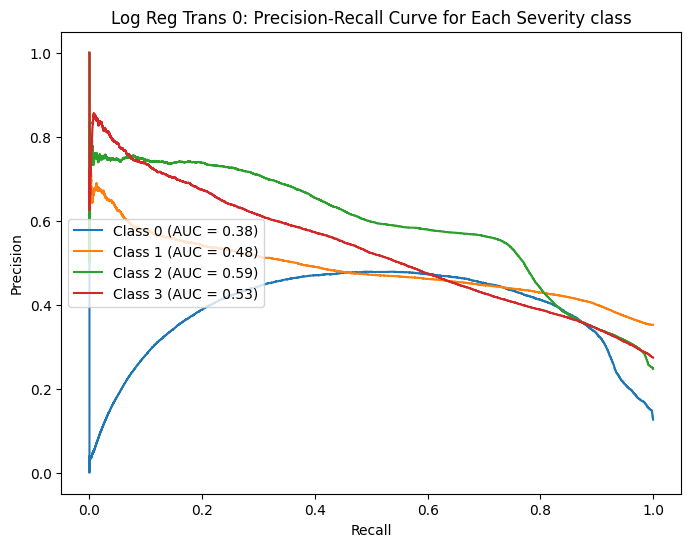

In [ ]:
log_reg_perf_0 = classification_task( model_lr_0, x_train_0, y_train_0, x_test_0, y_test_0, y_pred, "logistic_regression_0")
plot_precision_recall_curve(x_test_0, y_test_0, model_lr_0, 'Log Reg Trans 0')

In [ ]:
log_reg_perf_0

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
logistic_regression_0,0.502621,0.505075,0.502593,0.505075,0.501652,0.505075


### Decision Tree

In [ ]:
model_dt_0 = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=100, random_state=42)
model_dt_0.fit(x_train_0, y_train_0)
y_pred_dt_0 = model_dt_0.predict(x_test_0)
dec_tree_perf_0 = classification_task( model_dt_0, x_train_0, y_train_0, x_test_0, y_test_0, y_pred_dt_0, "Decision_tree_0")
dec_tree_perf_0

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Decision_tree_0,0.883204,0.87185,0.87153,0.87185,0.87161,0.87185


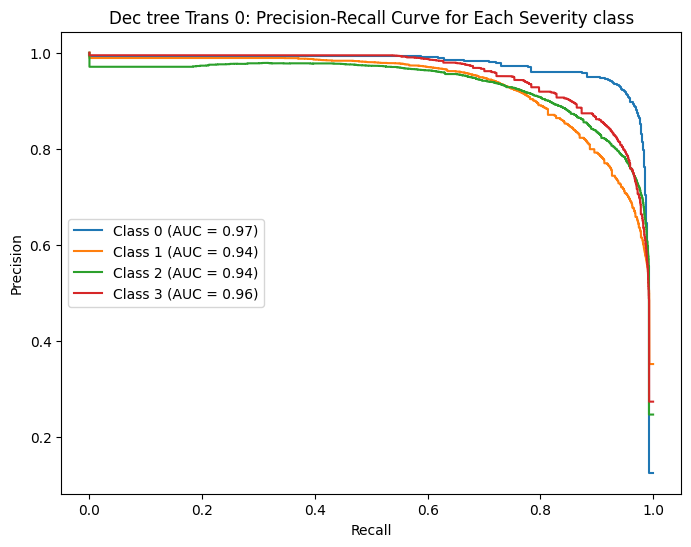

In [ ]:
plot_precision_recall_curve(x_test_0, y_test_0, model_dt_0, 'Dec tree Trans 0')

### Random Forest

In [ ]:
model_rf_0 = RandomForestClassifier()

model_rf_0.fit(x_train_0, y_train_0)
y_pred_rf_0 = model_rf_0.predict(x_test_0)
rf_perf_0 = classification_task( model_rf_0, x_train_0, y_train_0, x_test_0, y_test_0, y_pred_rf_0, "Random_Forest_0")
rf_perf_0

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random_Forest_0,0.999986,0.887042,0.887236,0.887042,0.886864,0.887042


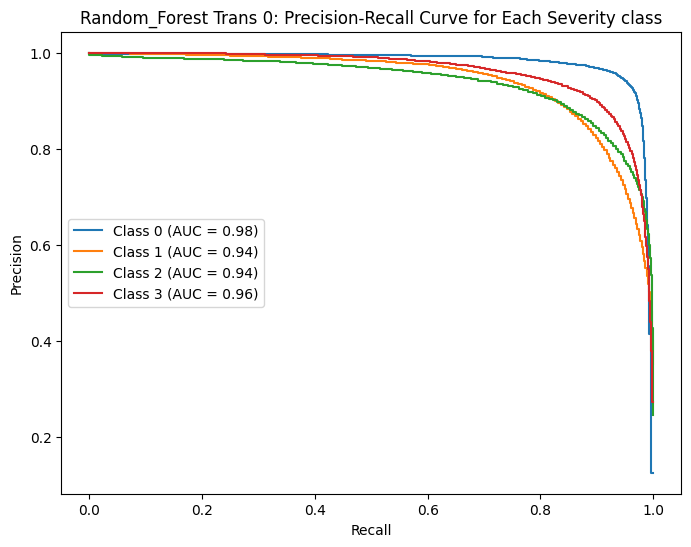

In [ ]:
plot_precision_recall_curve(x_test_0, y_test_0, model_rf_0, 'Random_Forest Trans 0')

###**AdaBoost Classifier**

In [ ]:
model_ada_0 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth = 15, min_samples_split=50),
    n_estimators=75, random_state=42)

model_ada_0.fit(x_train_0, y_train_0)
y_pred_ada_0 = model_ada_0.predict(x_test_0)
ada_perf_0 = classification_task( model_ada_0, x_train_0, y_train_0, x_test_0, y_test_0, y_pred_ada_0, "AdaBoost_trans_0")
ada_perf_0

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
AdaBoost_trans_0,0.946126,0.858167,0.858515,0.858167,0.857941,0.858167


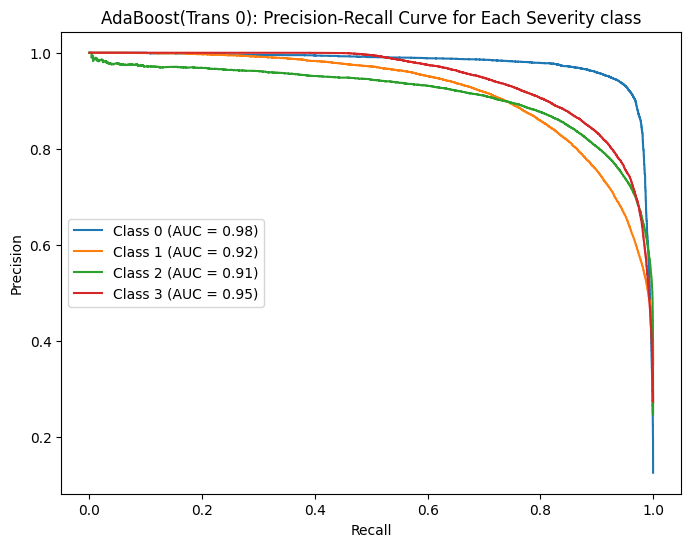

In [ ]:
plot_precision_recall_curve(x_test_0, y_test_0, model_ada_0, 'AdaBoost(Trans 0)')

### Voting Classifier

In [ ]:
model_voting_0 = VotingClassifier(
    estimators=[
        ('model_rf_0', model_rf_0),
        ('model_dt_0', model_dt_0),
        ('model_lr_0', model_lr_0)
    ], voting='soft')

model_voting_0.fit(x_train_0, y_train_0)
y_pred = model_voting_0.predict(x_test_0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


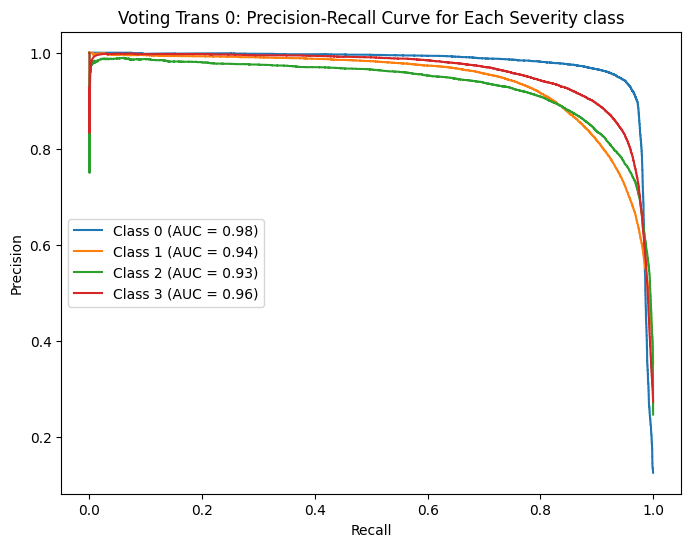

In [ ]:
voting_perf_0=classification_task( model_voting_0, x_train_0, y_train_0, x_test_0, y_test_0, y_pred, "Voting_0")
plot_precision_recall_curve(x_test_0, y_test_0, model_voting_0, 'Voting Trans 0')

In [ ]:
voting_perf_0

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Voting_0,0.956473,0.883958,0.884099,0.883958,0.883747,0.883958


## Transformation 1

In [ ]:
# Applying preprocessing according to Transformation 1

data_trans_1 = ext_sel_n_binner_1.fit_transform(data)
data_trans_1 = TreatOutliers().sophisticated(data_trans_1)

X_trans_1 = data_trans_1.drop('severity', axis=1)
X_trans_1 = pipe_trans_1.fit_transform(X_trans_1) # applying preprocessing

y_trans_1 = data_trans_1.loc[:, 'severity']

# Splitting the data
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X_trans_1, y_trans_1, test_size=0.2, stratify=y_trans_1, random_state=101, shuffle=True)
print(x_train_1.shape, y_train_1.shape)

(426742, 26) (426742,)


### **Logistic Regression**

In [ ]:
model_lr_1 = LogisticRegression(solver='saga', max_iter=500, random_state=42)
model_lr_1.fit(x_train_1, y_train_1)
y_pred = model_lr_1.predict(x_test_1)
log_reg_perf_1 = classification_task( model_lr_1, x_train_1, y_train_1, x_test_1, y_test_1, y_pred, "logistic_regression_Trans_1")
log_reg_perf_1

In [ ]:
plot_precision_recall_curve(x_test_1, y_test_1, model_lr_1, 'Log Reg(Trans 1)')

### **Decision Tree**

In [ ]:
model_dt_1 = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=100, random_state=42)
model_dt_1.fit(x_train_1, y_train_1)
y_pred = model_dt_1.predict(x_test_1)
dec_tree_perf_1 = classification_task( model_dt_1, x_train_1, y_train_1, x_test_1, y_test_1, y_pred, "Decision_tree_trans_1")
dec_tree_perf_1

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Decision_tree_trans_1,0.624576,0.601419,0.599362,0.601419,0.598221,0.601419


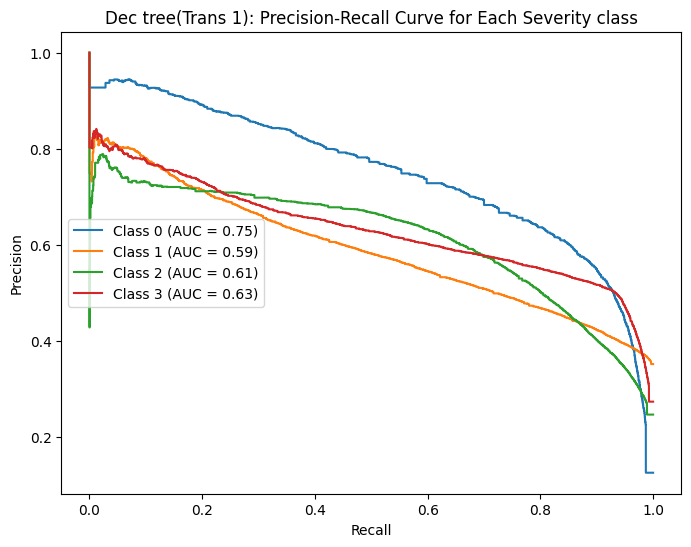

In [ ]:
plot_precision_recall_curve(x_test_1, y_test_1, model_dt_1, 'Dec tree(Trans 1)')

###**Random Forest**

In [ ]:
model_rf_1 = RandomForestClassifier()
model_rf_1.fit(x_train_1, y_train_1)
y_pred_rf = model_rf_1.predict(x_test_1)
rf_perf_1 = classification_task( model_rf_1, x_train_1, y_train_1, x_test_1, y_test_1, y_pred_rf, "Random_Forest_trans_1")
rf_perf_1

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random_Forest_trans_1,0.992527,0.641977,0.639811,0.641977,0.63937,0.641977


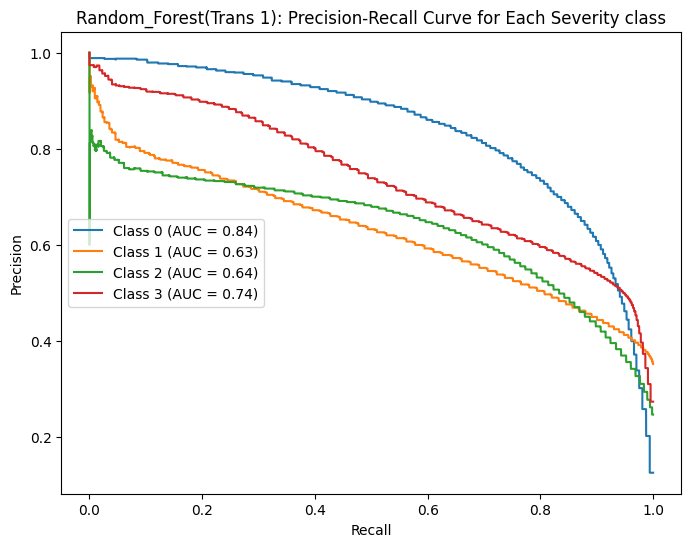

In [ ]:
plot_precision_recall_curve(x_test_1, y_test_1, model_rf_1, 'Random_Forest(Trans 1)')

###**AdaBoost Classifier**

In [ ]:
model_ada_1 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth = 15, min_samples_split=50),
    n_estimators=75, random_state=42)

model_ada_1.fit(x_train_1, y_train_1)
y_pred = model_ada_1.predict(x_test_1)
ada_perf_1 = classification_task( model_ada_1, x_train_1, y_train_1, x_test_1, y_test_1, y_pred, "AdaBoost_trans_1")
ada_perf_1

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
AdaBoost_trans_1,0.772471,0.583169,0.589754,0.583169,0.585488,0.583169


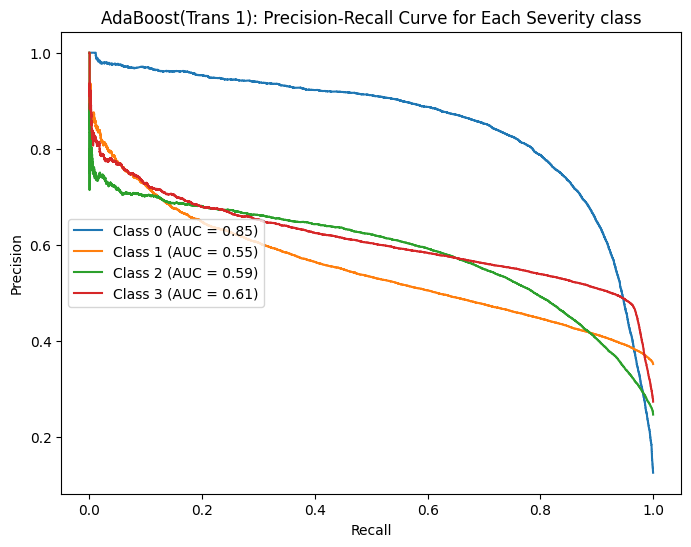

In [ ]:
plot_precision_recall_curve(x_test_1, y_test_1, model_ada_1, 'AdaBoost(Trans 1)')

###**Voting Classifier**

In [ ]:
model_voting_1 = VotingClassifier(
    estimators=[
        ('model_rf_1',model_rf_1),
        ('model_ada_1', model_ada_1),
        ('model_dt_1', model_dt_1)
    ], voting='soft')

model_voting_1.fit(x_train_1, y_train_1)
y_pred_voting = model_voting_1.predict(x_test_1)
voting_perf_1 = classification_task( model_voting_1, x_train_1, y_train_1, x_test_1, y_test_1, y_pred_voting, "voting_trans_1")
voting_perf_1

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
voting_trans_1,0.91994,0.643496,0.641903,0.643496,0.640782,0.643496


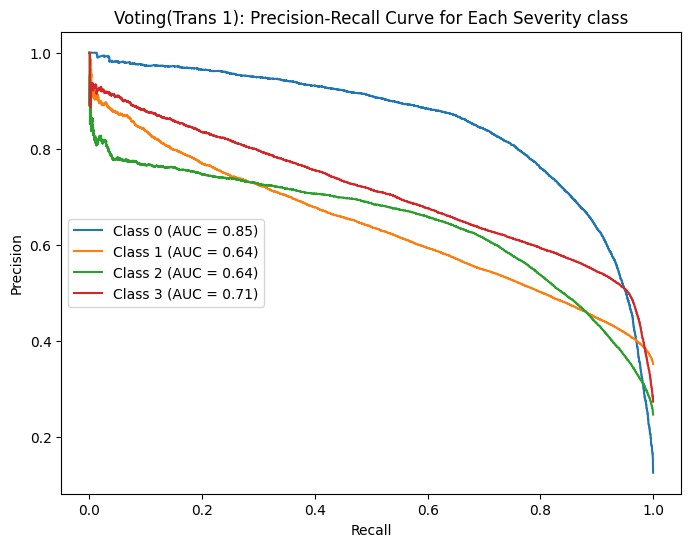

In [ ]:
plot_precision_recall_curve(x_test_1, y_test_1, model_voting_1, 'Voting(Trans 1)')

## Model Comparision

In [ ]:
pd.concat([log_reg_perf_0,dec_tree_perf_0,rf_perf_0,ada_perf_0,voting_perf_0,
           log_reg_perf_1 ,dec_tree_perf_1,rf_perf_1,ada_perf_1,voting_perf_1]).sort_values(by='Test_Score',ascending=False)

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random_Forest_0,0.999986,0.887042,0.887236,0.887042,0.886864,0.887042
Voting_0,0.956473,0.883958,0.884099,0.883958,0.883747,0.883958
Decision_tree_0,0.883204,0.871850,0.871530,0.871850,0.871610,0.871850
AdaBoost_trans_0,0.946126,0.858167,0.858515,0.858167,0.857941,0.858167
voting_trans_1,0.919940,0.643496,0.641903,0.643496,0.640782,0.643496
Random_Forest_trans_1,0.992527,0.641977,0.639811,0.641977,0.639370,0.641977
Decision_tree_trans_1,0.624576,0.601419,0.599362,0.601419,0.598221,0.601419
AdaBoost_trans_1,0.772471,0.583169,0.589754,0.583169,0.585488,0.583169
logistic_regression_0,0.502621,0.505075,0.502593,0.505075,0.501652,0.505075
logistic_regression_Trans_1,0.487976,0.486587,0.486527,0.486587,0.486500,0.486587


# Hyper-parameter Tuning



Possible hyper-parameters to tune w.r.t model (with sample values).

Random Forest:
```
     'n_estimators': [50, 100, 200]
     'criterion': ['gini', 'entropy']
     'max_depth': [None, 10, 20]
     'min_samples_split': [2, 5, 10]
     'min_samples_leaf': [1, 2, 4]
     'max_features': ['auto', 'sqrt', 'log2']
```


As the dataset is huge, and we do not have enough resources to tune the entire dataset at once, a subset of it which is representative of the original dataset shall be created for hyper-parameter tuning.

In [ ]:
# Taking 50,000 records from each severity class
import pandas as pd

subset_df = pd.DataFrame()
df_hyp = pd.DataFrame(np.c_[x_train_1, y_train_1])

samples_per_class = 50000
subset_df = df_hyp.groupby(df_hyp.columns[-1], group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_class)))
subset_df = subset_df.reset_index(drop=True)

In [ ]:
print(len(subset_df))

200000


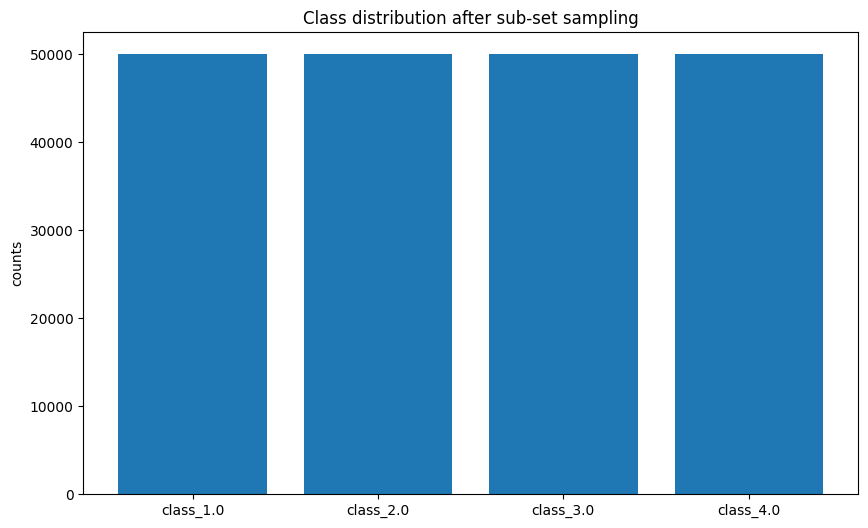

In [ ]:
subset_df.reset_index(drop=True, inplace=True)
counts = subset_df.iloc[:, -1].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks(counts.index, labels=[f"class_{i}" for i in counts.index])
plt.title("Class distribution after sub-set sampling")
plt.ylabel("counts")
plt.show()

In [ ]:
X_hyp = subset_df.iloc[:, :-1]
y_hyp = subset_df.iloc[:, -1]

In [ ]:
from sklearn.model_selection import train_test_split

X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = train_test_split(X_hyp, y_hyp, test_size=0.3, stratify=y_hyp)

In [ ]:
# Random Forest - Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

rf_param_grid = { 'n_estimators': [50, 200],
     'criterion': ['gini', 'entropy'],
     'max_depth': [10, 20],
     'min_samples_split': [5, 10],
     'min_samples_leaf': [1, 2, 4],
     'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(RandomForestClassifier(),
                      param_grid=rf_param_grid,
                      scoring='accuracy',
                      cv=3, n_jobs=-1)
rf_grid.fit(X_train_hyp, y_train_hyp)
rf_grid.best_params_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
# Fitting the best params from hyper-parameter tuning to Random Forest model
# for transformation 1 data
model_rf_hyp = RandomForestClassifier(criterion='entropy',
max_depth = 20,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 min_samples_split = 5,
 n_estimators=200)

model_rf_hyp.fit(x_train_1, y_train_1)
y_pred_rf = model_rf_hyp.predict(x_test_1)
rf_perf_1 = classification_task( model_rf_hyp, x_train_1, y_train_1, x_test_1, y_test_1, y_pred_rf, "Random_Forest_trans_!")
rf_perf_1

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random_Forest_trans_!,0.792291,0.633898,0.633035,0.633898,0.630398,0.633898


#Conclusion

## Results

- **Best results** were achieved using the sequence of preprocessing steps defined in the **transformation 0** pipeline
- Among all the combinations of preprocessing steps with different models, **Decision Tree classifier avoids overfitting** and gives best results **with Transformation 0 pipeline**.
- Thus, we achieve a **test accuracy of 87.2%**

## Observations
1. Increasing complexity of preprocessing doesn't guarantee more accuracy<br>
    - Though Transformation-1 pipeline applies more complicated preprocessing steps, it doesn’t give better accuracy

2. Grid Search might not always be feasible<br>
    - Grid search took significantly long time(in hours) since we had very large training data

## Uniqueness

1. Balanced Random sampling
    - None of the existing solutions take immense size of the data into consideration & thus their code cannot be run on a local computer without high computation resources.
    - We've taken real world issue into consideration, sampled the data and achieved impressive results with minimal resources.

2. Multiple preprocessing strategies
    - We've tried multiple strategies to deal with noise in the data which combines domain knowledge.

3. Careful selection of Evaluation Metrics
    - Unlike many implementations that simply uses accuracy as an evaluation metrics, we've chosen a metric that takes imbalance of target classes into consideration.